In [1]:
__author__ = 'Erwin Chen'
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.io import fits
from astropy.table import Table
import numpy as np
import scipy.stats as stats
from sklearn.utils.extmath import cartesian
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import mixture
from sklearn.metrics.cluster import v_measure_score
from sklearn.covariance import EmpiricalCovariance, MinCovDet, EllipticEnvelope

C:\Users\jouse_000\Anaconda2_32\lib\site-packages\IPython\kernel\__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
elements = np.array(['Al', 'Ca', 'C', 'Fe', 'K', 'Mg', 'Mn', 'Na', 'Ni', 'N', 'O', 'Si', 'S', 'Ti', 'V'])
def get_corr(chem, elements):
    '''
    get correlations among 15 elements.
    
    :param chem:
        The matrix that contains chemical abundances with 
        the shape (num_stars, num_elements)
        
    :param elements:
        The array that contains the names of element abundances
        
    :returns:
    The correlation matrix
    '''
    n_elements = len(elements)
    # get the correlation matrix for all stars
    correlation = np.corrcoef(chem.T)
    # plot correlation matrix
    fig_corr = plt.figure()
    plt.pcolor(correlation)
    plt.colorbar()
    plt.yticks(np.arange(0.5,n_elements + .5), elements)
    plt.xticks(np.arange(0.5,n_elements + .5), elements)
    plt.xlim(0,n_elements)
    plt.ylim(0,n_elements)
    plt.show()
    return correlation

In [3]:
def get_PCA(chem):
    '''
    get the transformed data after PCA.
    
    :param chem:
        The matrix that contains chemical abundances with 
        the shape (num_stars, num_elements)
        
    :returns:
    transform data
    '''
    # perform PCA
    n_components = chem[0].size
    pca = PCA(n_components=n_components)
    chem_pca = pca.fit_transform(chem)
    # plot results from PCA
    ratio = np.around(pca.explained_variance_ratio_, decimals=3)
    # plot explained variance ratio
    ratio_increment = [sum(ratio[:n+1]) for n in range(n_components)]
    ratio_increment = np.around(ratio_increment, decimals=3)
    print ratio_increment
    f, ax = plt.subplots()
    x = range(1,n_components+1)
    ax.plot(x, ratio_increment)
    ax.set_xlabel('principal component')
    ax.set_ylabel('ratio')
    ax.set_xticks(x)
    ax.set_xlim(0.5, x[-1] + .5)
    ax.set_ylim(ratio_increment[0] * .95, 1)
    plt.show()
    return chem_pca

In [4]:
# # load data from APOGEE
# load data from fits file
ap_file = fits.open('results-unregularized-matched.fits')
ap_file.info()
ap_data = ap_file[1].data
feature_names = ['APOGEE_ID', 'GLON', 'GLAT', 'RA', 'DEC', 'VHELIO_AVG', 'LOGG', 'TEFF', 'PMRA', 'PMDEC', 'AL_H', 'CA_H', 'C_H',
                'FE_H', 'K_H', 'MG_H', 'MN_H', 'NA_H', 'NI_H', 'N_H', 'O_H', 'SI_H', 'S_H', 'TI_H', 'V_H', 'SNR']
element_names = ['AL_H', 'CA_H', 'C_H', 'FE_H', 'K_H', 'MG_H', 'MN_H', 'NA_H', 'NI_H', 'N_H', 'O_H', 'SI_H', 'S_H', 'TI_H', 'V_H']
ap_cols = []
for name in feature_names:
    ap_cols.append(ap_data.field(name))
ap_cols = np.array(ap_cols)
ap_cols = ap_cols.T
dtype = ['float' for n in range(len(feature_names))]
dtype[0] = 'string'
ap_table = Table(data=ap_cols, names=feature_names, dtype=dtype, meta={'name': 'apogee table'})

Filename: results-unregularized-matched.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU      16   (9974,)      uint8   
1    Joined      BinTableHDU    351   150677R x 169C   [18A, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, 45A, 34A, 44A, 34A, 8A, I, 16A, E, E, E, E, E, E, D, D, D, D, J, J, 116A, J, I, E, J, 129A, J, 59A, E, E, E, E, E, E, E, E, E, E, E, E, E, E, 2E, 2E, 2E, 2E, 5A, 6A, 4A, I, 7E, 7E, 49E, 49E, 15E, 15E, 15E, 15E, E, E, E, E, E, E, E, E, E, 2A, J, 153A, 7J, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, 15E, 15J, 18A, 12A, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, 17A, E, E, I, I, E, E, 20A, 737A, 665A, 50J, 50J, L]   


In [5]:
# get stars with 15 elements
ap_stars_15 = np.where((ap_table['AL_H'] > -9999.0) 
                    * (ap_table['CA_H'] > -9999.0) 
                    * (ap_table['C_H'] > -9999.0) 
                    * (ap_table['FE_H'] > -9999.0) 
                    * (ap_table['K_H'] > -9999.0) 
                    * (ap_table['MG_H'] > -9999.0) 
                    * (ap_table['MN_H'] > -9999.0) 
                    * (ap_table['NA_H'] > -9999.0) 
                    * (ap_table['NI_H'] > -9999.0) 
                    * (ap_table['N_H'] > -9999.0) 
                    * (ap_table['O_H'] > -9999.0) 
                    * (ap_table['SI_H'] > -9999.0) 
                    * (ap_table['S_H'] > -9999.0) 
                    * (ap_table['TI_H'] > -9999.0) 
                    * (ap_table['V_H'] > -9999.0) 
                   )[0]
ap_table_15 = ap_table[ap_stars_15]

C:\Users\jouse_000\Anaconda2_32\lib\site-packages\ipykernel\__main__.py:16: RuntimeWarning: invalid value encountered in greater


## Correlation matrix and PCA
First, we calculate the correlation coefficient of each pair of elements and present the direct results in a matrix. Except for Na, N and V, the other 12 elements among each other share a correlation coefficint of 0.85 or above. Na and N are about 0.75 or above. The elements are highly correlated with each other. The low correlation of V is likely due to low precision. We confirm this result with PCA. The first principal component accounts for 81.2% of variance in the data. When the number of principal components increases to 4, we can account for 95% of variance in the data. 

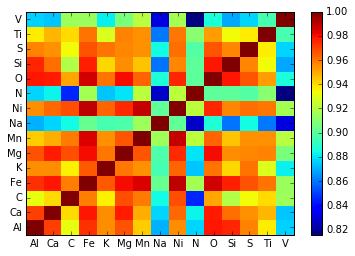

[ 0.933  0.951  0.966  0.978  0.983  0.987  0.99   0.992  0.994  0.996
  0.997  0.998  0.999  0.999  0.999]


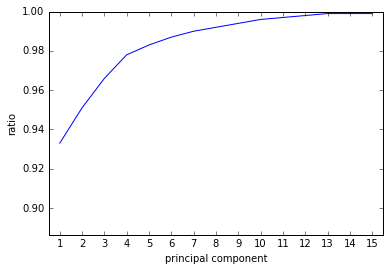

In [6]:
# correlation and PCA for 15 elements
ap_chem_15 = np.array([np.array(ap_table_15[element_names][element], dtype=float) for element in element_names])
ap_chem_15 = ap_chem_15.T
ap_15_corr = get_corr(ap_chem_15, elements)
ap_15_PCA = get_PCA(ap_chem_15)

Second, we apply PCA to 10 elements selected by Conroy. We find that with one principal component, we are able to account for 91.2% of variance in the data. With four principal components, the percentage increases to 96.7%. The increase percentages show that we are losing extra information by using only 10 elements. However, the small increase shows that the amount of missing information is probably negligible. Later, we will show with KMeans that it is indeed better to use these 10 elements instead all 15 elements. 

[ 0.969  0.98   0.986  0.99   0.993  0.995  0.997  0.998  0.999  0.999]


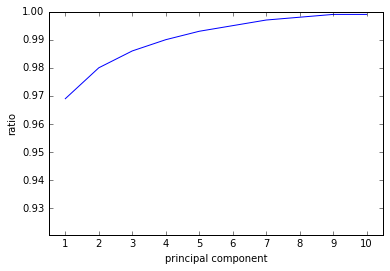

In [7]:
# correlation and PCA for 10 elements
element_names_10 = ['AL_H', 'CA_H', 'FE_H', 'K_H', 'MG_H', 'MN_H', 'NI_H', 'O_H', 'SI_H', 'S_H']
elements_10 = ['Al', 'Ca', 'Fe', 'K', 'Mg', 'Mn', 'Ni', 'O', 'Si', 'S']
element_labels_10 = ['[Al/H]', '[Ca/H]', '[Fe/H]', '[K/H]', '[Mg/H]', '[Mn/H]', '[Ni/H]', '[O/H]', '[Si/H]', '[S/H]']
ap_chem_10 = np.array([np.array(ap_table_15[element_names_10][element], dtype=float) for element in element_names_10])
ap_chem_10 = ap_chem_10.T
ap_10_PCA = get_PCA(ap_chem_10)

In [8]:
# load known members
known_clusters = np.loadtxt('table4.dat', usecols=(0, 1), dtype=('S', 'S'), unpack=True)
member_IDs = np.intersect1d(ap_table_15['APOGEE_ID'], known_clusters[0])
members_kc = np.array([np.where(ID == known_clusters[0])[0][0] for ID in member_IDs])
members_table = np.array([np.where(ID == ap_table_15['APOGEE_ID'])[0][0] for ID in member_IDs])
ap_tb_mem = ap_table_15[members_table]
name_col = Table.Column(name='cluster_name', data=known_clusters[1][members_kc])
ap_tb_mem.add_column(name_col)

In [9]:
# get six clusters
ap_tb_mem = ap_tb_mem.group_by('cluster_name')
# print ap_tb_mem.groups.keys
# print ap_tb_mem.groups.indices
names = ['M107', 'M3', 'M67', 'M13', 'M5', 'N6819']
index = []
k = 0
for group in ap_tb_mem.groups:
    if group['cluster_name'][0] in names:
        index.append(k)
    k += 1
ap_tb_check = ap_tb_mem.groups[index]

## Analysis of Known Members
The chemical homogeneity in each cluster is less than that in all stars. This conclusion seems to contradict that stars from the same cluster can be discerned from the background. 

M107


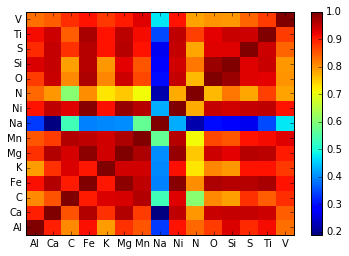

[ 0.821  0.916  0.951  0.973  0.985  0.993  0.995  0.997  0.998  0.999
  0.999  0.999  0.999  0.999  0.999]


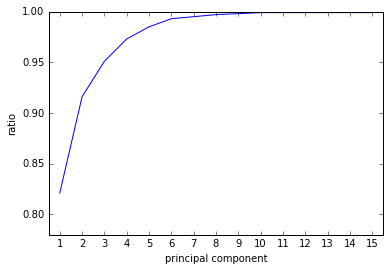

M13


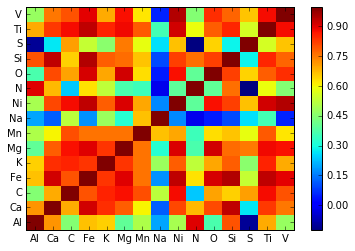

[ 0.61   0.811  0.95   0.967  0.98   0.988  0.994  0.996  0.997  0.998
  0.999  1.     1.     1.     1.   ]


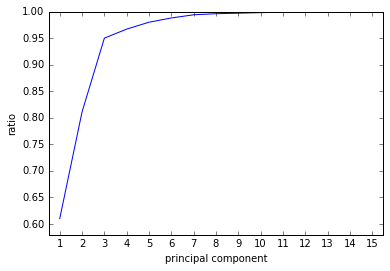

M3


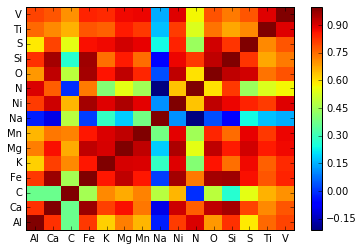

[ 0.667  0.859  0.928  0.968  0.98   0.987  0.991  0.994  0.996  0.998
  0.999  1.     1.     1.     1.   ]


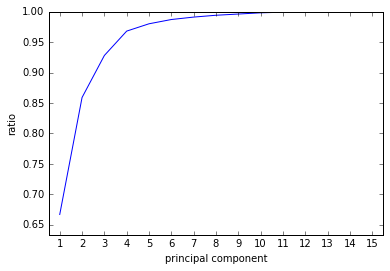

M5


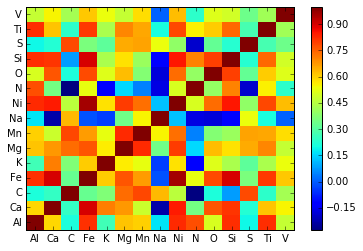

[ 0.475  0.757  0.892  0.936  0.96   0.974  0.982  0.988  0.993  0.995
  0.997  0.998  0.999  0.999  0.999]


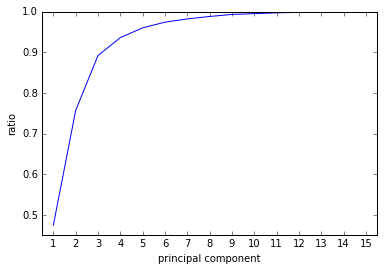

M67


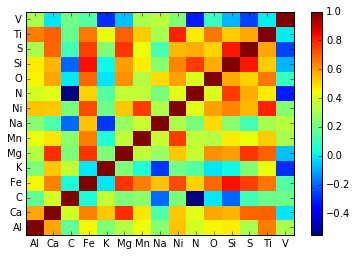

[ 0.408  0.661  0.793  0.857  0.907  0.935  0.958  0.973  0.983  0.991
  0.996  0.998  0.999  1.     1.   ]


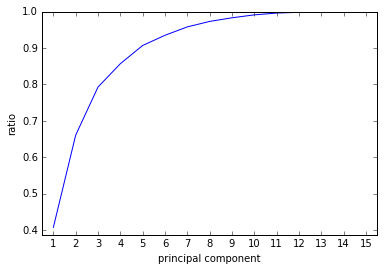

N6819


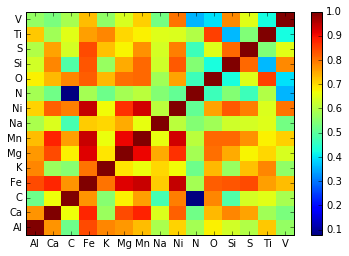

[ 0.683  0.809  0.875  0.922  0.948  0.969  0.984  0.99   0.994  0.997
  0.999  1.     1.     1.     1.   ]


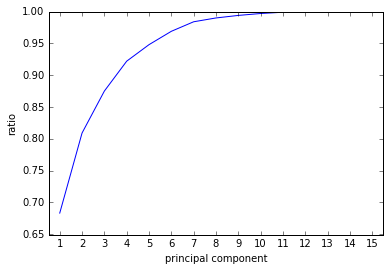

In [10]:
# PCA for each known cluster (15 elements)
for group in ap_tb_check.groups:
    ap_chem_cl = np.array([np.array(group[element], dtype=float) for element in element_names])
    ap_chem_cl = ap_chem_cl.T
    print group['cluster_name'][0]
    ap_cl_corr = get_corr(ap_chem_cl, elements)
    ap_cl_PCA = get_PCA(ap_chem_cl)
    plt.show()

M107
[ 0.928  0.964  0.984  0.992  0.996  0.998  0.999  1.     1.     1.   ]


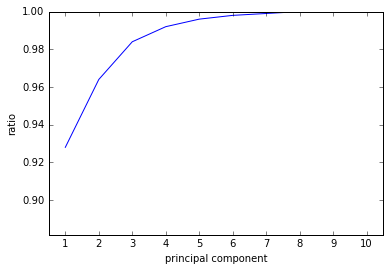

M13
[ 0.734  0.933  0.962  0.978  0.99   0.996  0.998  1.     1.001  1.001]


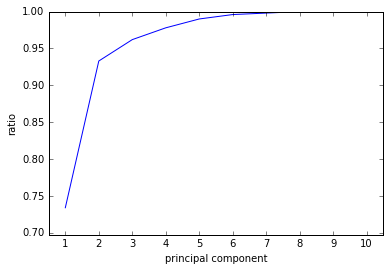

M3
[ 0.842  0.948  0.977  0.987  0.993  0.996  0.998  0.999  1.     1.   ]


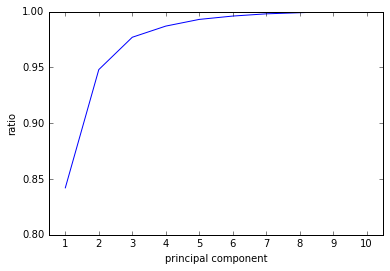

M5
[ 0.733  0.876  0.942  0.973  0.985  0.992  0.997  0.999  1.     1.001]


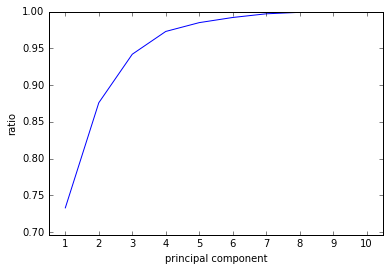

M67
[ 0.564  0.728  0.836  0.894  0.936  0.964  0.979  0.993  0.998  1.   ]


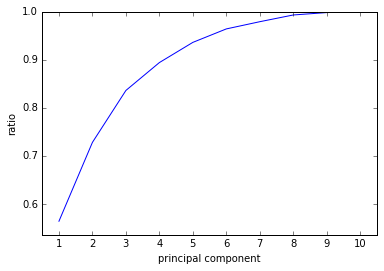

N6819
[ 0.8    0.88   0.924  0.96   0.981  0.99   0.995  0.998  0.999  1.   ]


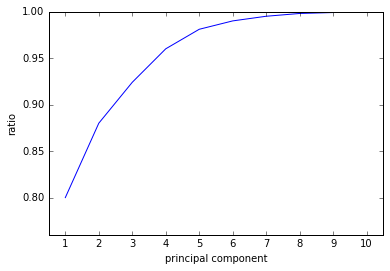

In [11]:
# PCA for each known cluster (10 elements)
for group in ap_tb_check.groups:
    ap_chem_cl = np.array([np.array(group[element], dtype=float) for element in element_names_10])
    ap_chem_cl = ap_chem_cl.T
    print group['cluster_name'][0]
    ap_cl_PCA = get_PCA(ap_chem_cl)

The following is an error chart for all 15 elements of known members. Each line marks the mean chemical abundances for 15 elements, with two standard deviations as error for each element. The reason for picking two standard deviations is that most members in fact lie in the chemical space between one and two standard deviations. From the chart, we can immediately see that Al, Na, N and V have little use for separating the six clusters. For the other elements, they are limited to separating the six clusters into three groups: M67 and N6819, M107 and the rest as one group. 

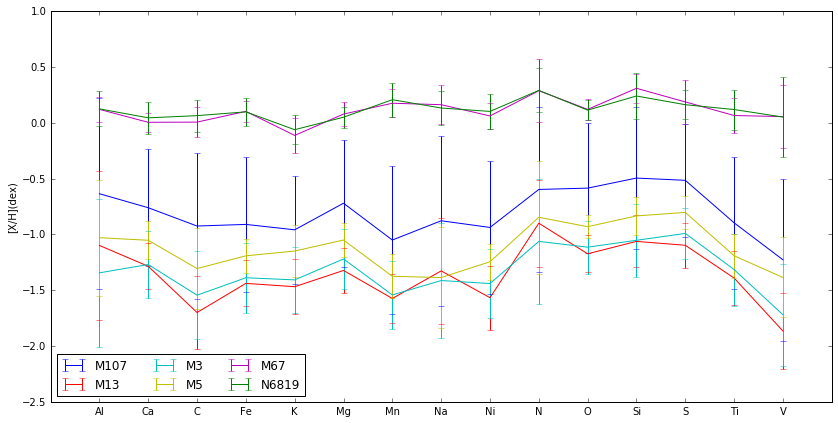

In [12]:
colors = ['b', 'r', 'c', 'y', 'm', 'g']
k = 0
fig = plt.figure(figsize=(14,7))
x = range(15)
for group in ap_tb_check.groups:
    ap_chem_cl = np.array([np.array(group[element], dtype=float) for element in element_names])
    ap_chem_cl = ap_chem_cl.T
    ap_chem_mean = np.zeros(len(ap_chem_cl[0]))
    ap_chem_error = np.zeros(len(ap_chem_cl[0]))
    for n in range(len(ap_chem_cl[0])):
        ap_chem_mean[n] = np.mean(ap_chem_cl[:,n])
        ap_chem_error[n] = np.std(ap_chem_cl[:,n])
    plt.errorbar(x, ap_chem_mean, yerr=ap_chem_error*2., color=colors[k], label=group['cluster_name'][0])
    k += 1
plt.xticks(np.arange(15), elements)
plt.xlim(-1, 15)
plt.ylabel('[X/H](dex)')
plt.legend(loc='lower left', ncol=3)
plt.show()

In [13]:
# use spectra to retreive chemically similar stars instead of using derived chemical abundances

## [X/H]
We plot the six clusters in two dimensional space for each pair of the 15 elements. Each dot represents a member star in a cluster. The colors represent different clusters. For all pairs of elements, M67 and N6819 are impossible to separate. The rest of the clusters can be separated in most pairs of elements. 

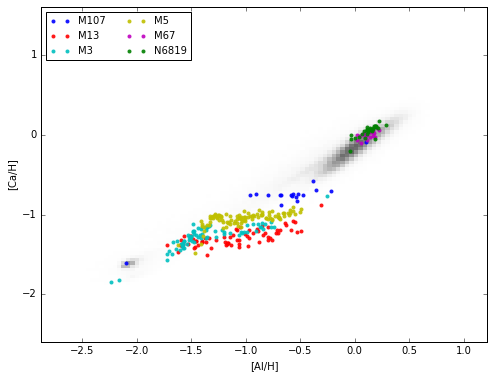

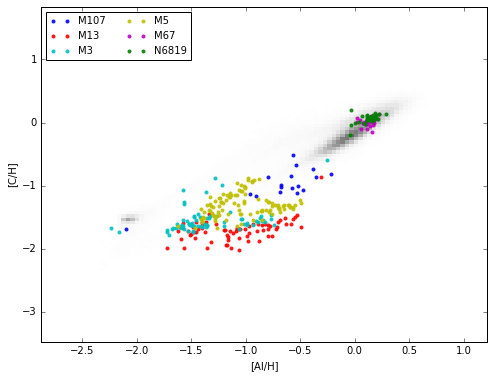

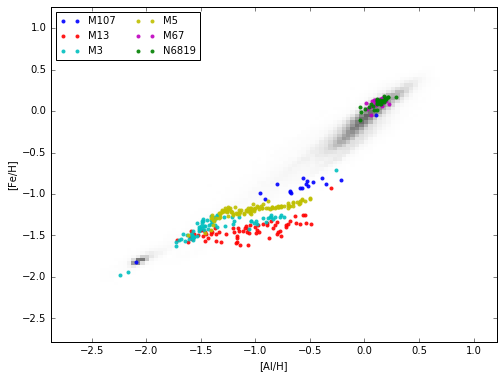

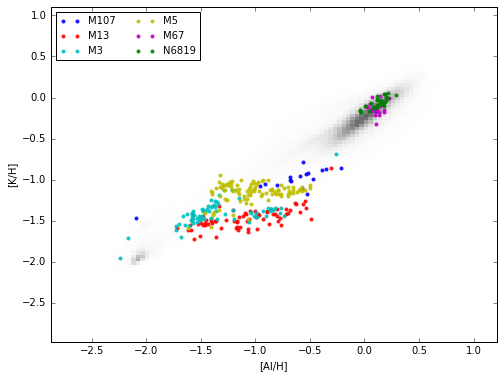

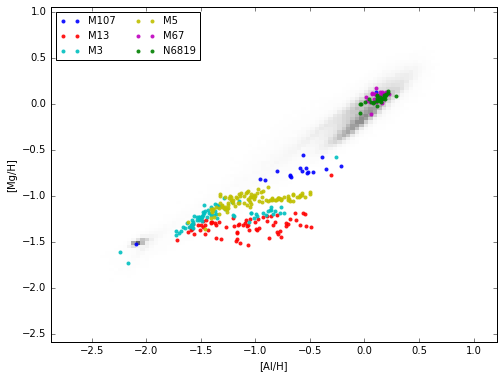

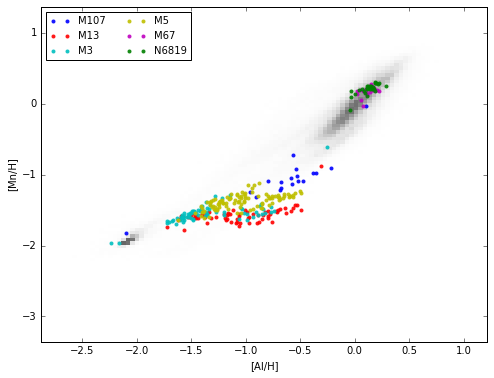

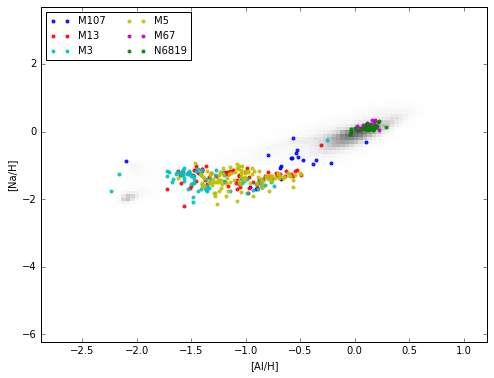

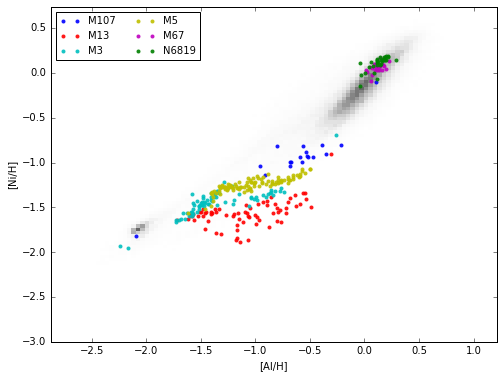

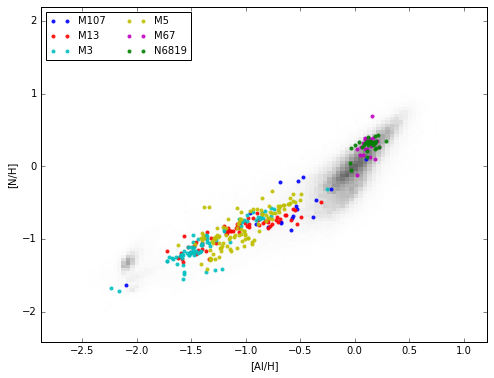

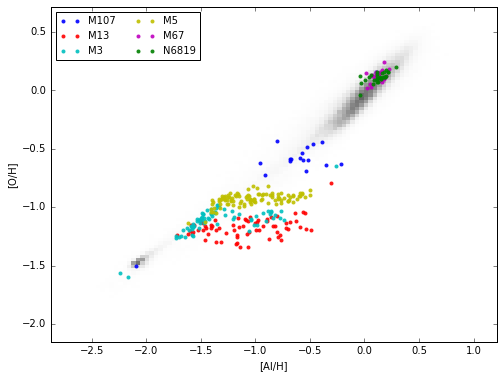

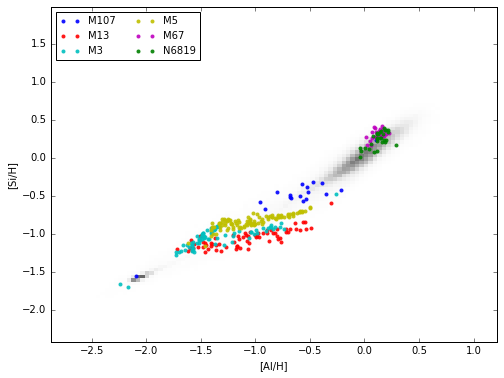

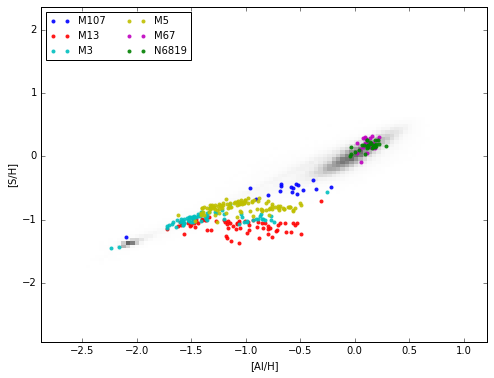

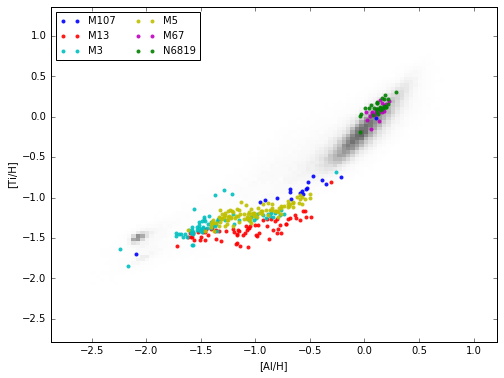

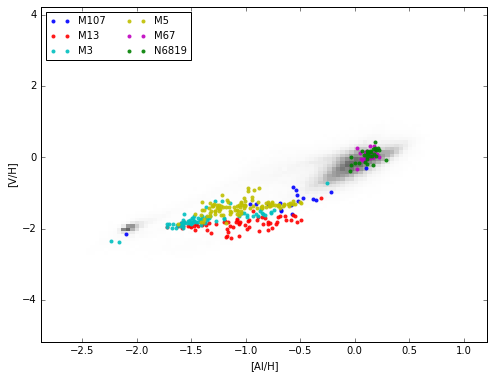

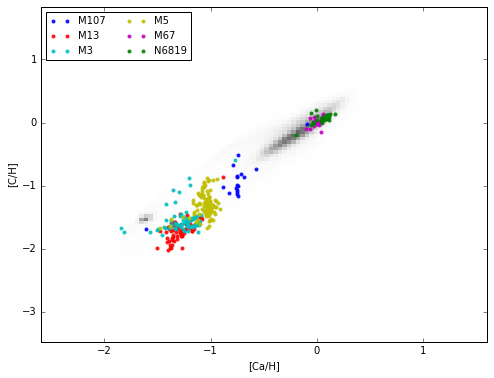

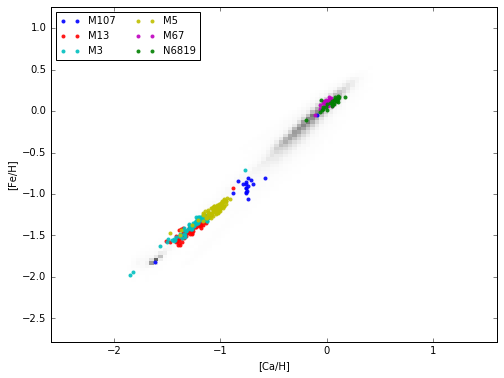

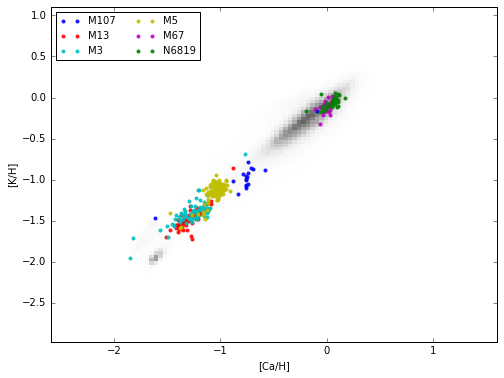

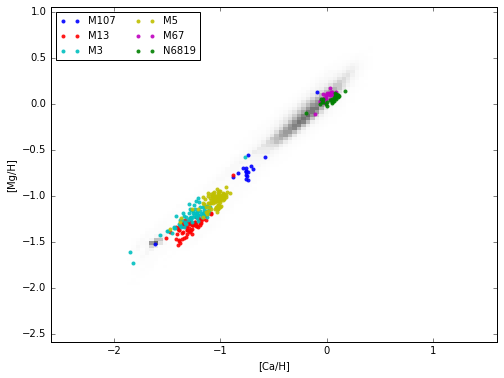

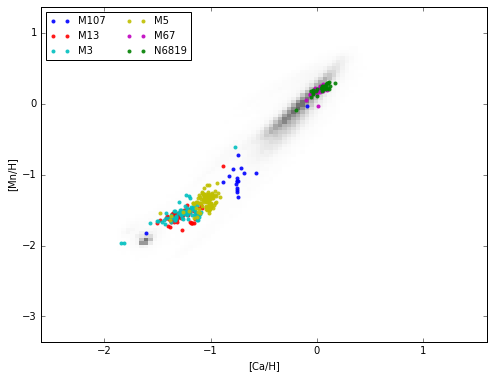

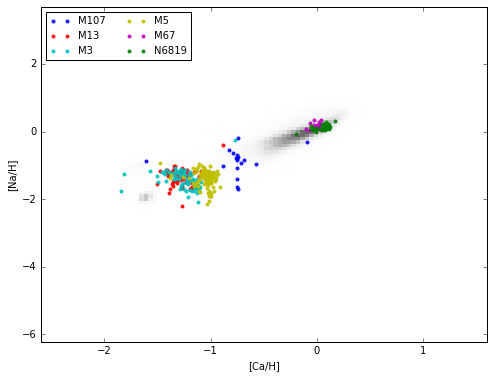

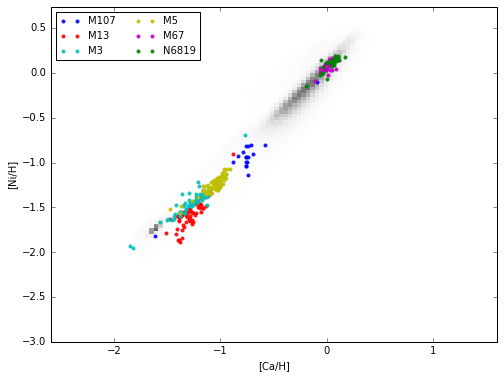

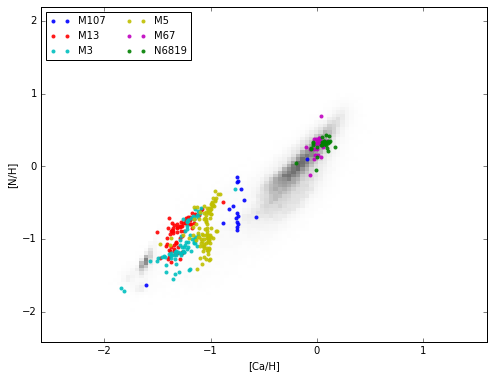

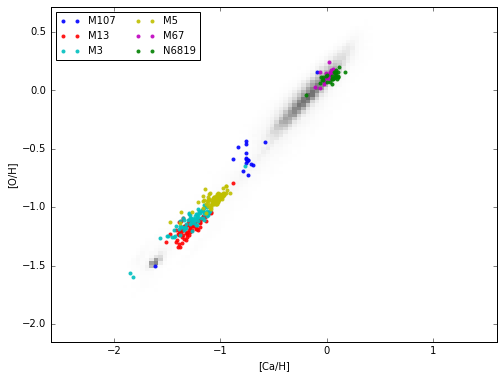

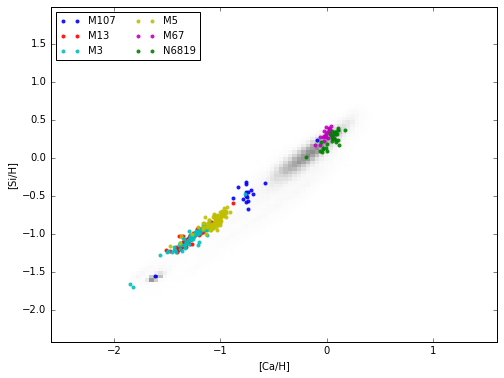

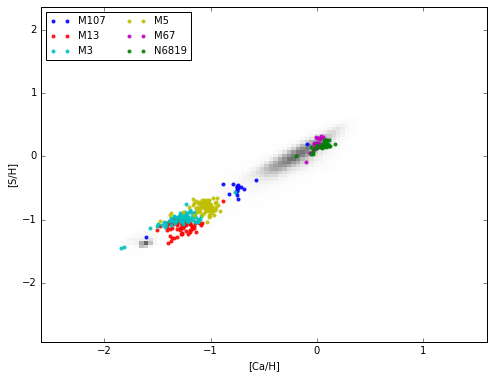

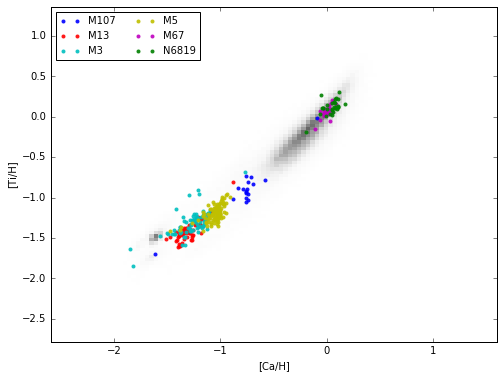

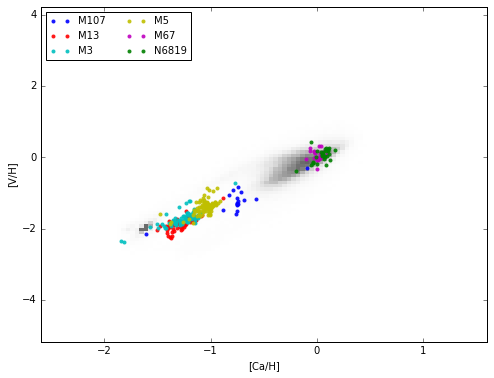

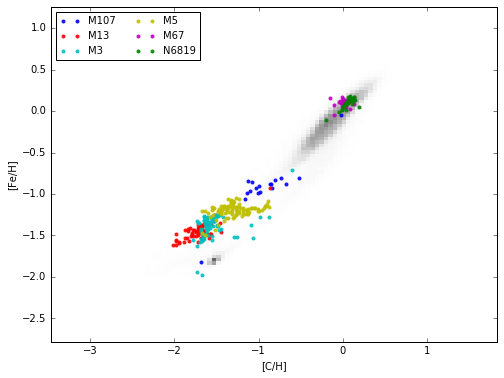

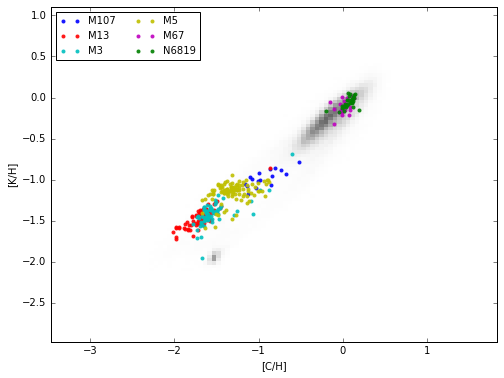

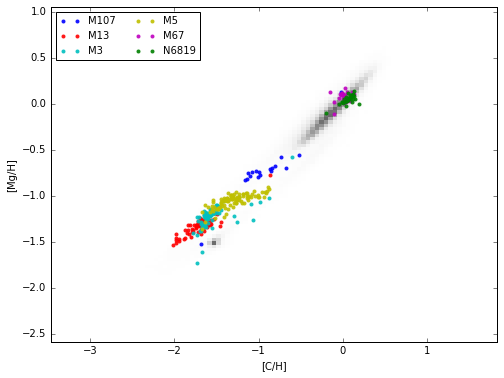

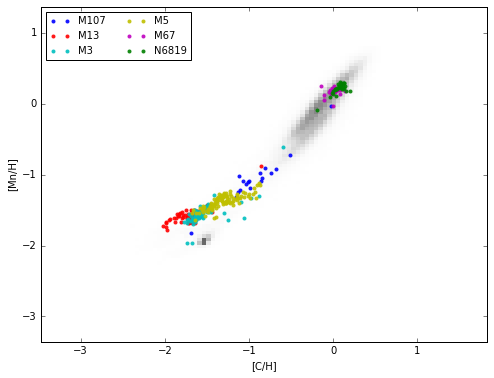

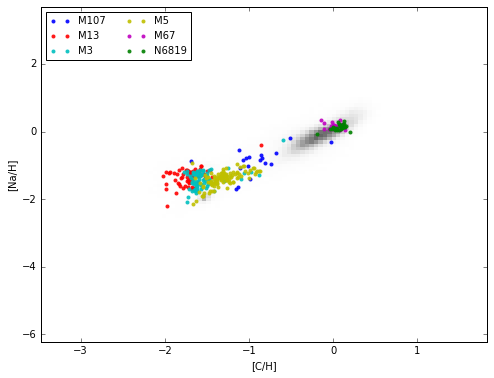

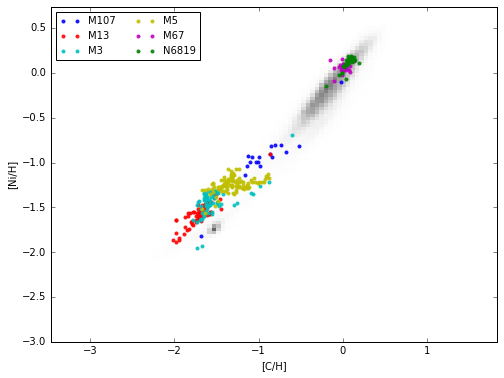

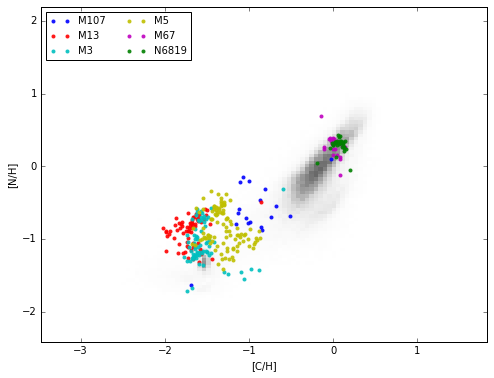

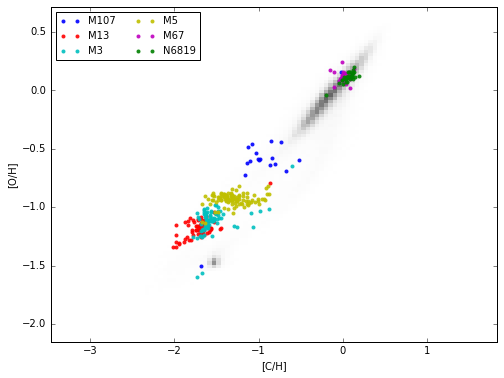

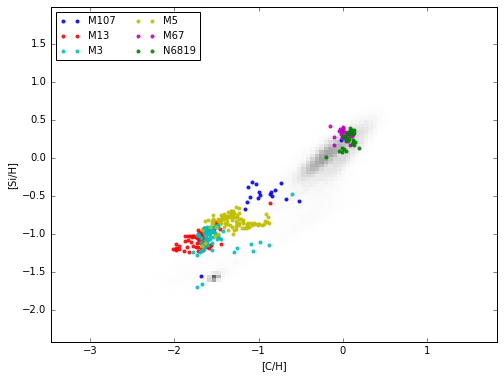

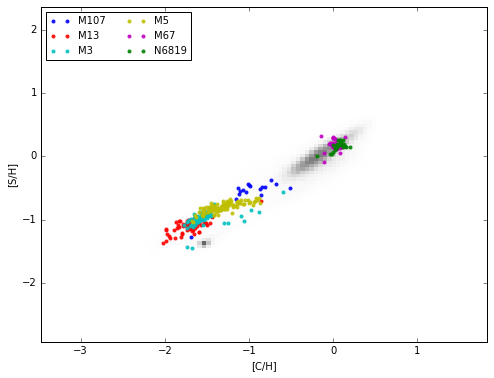

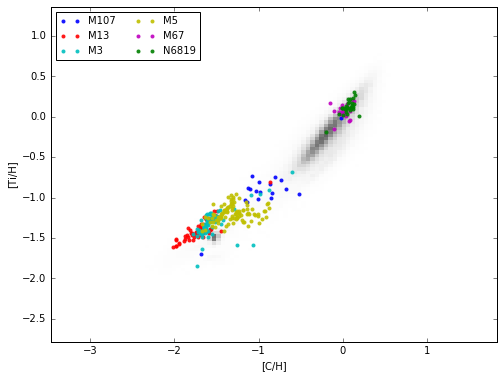

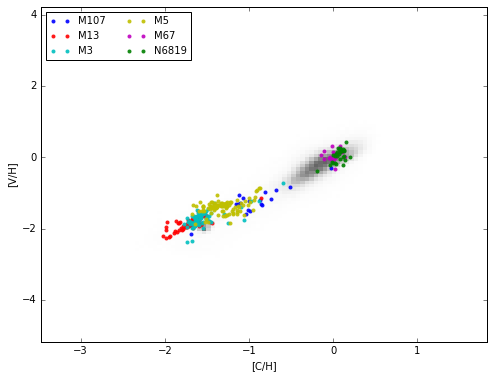

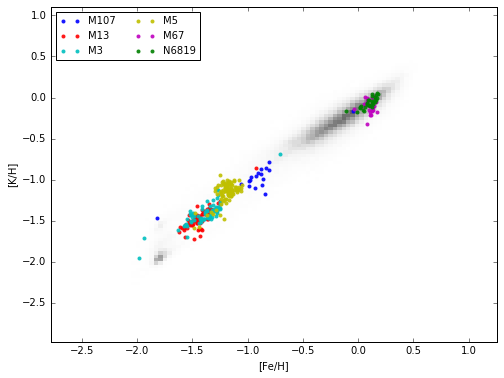

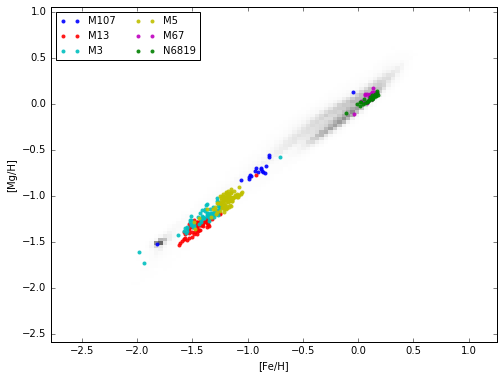

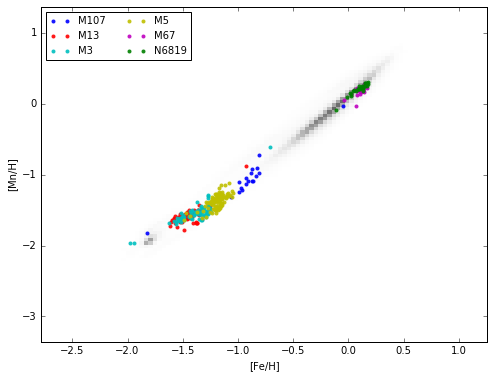

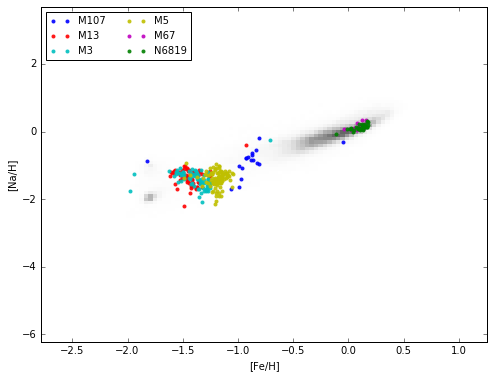

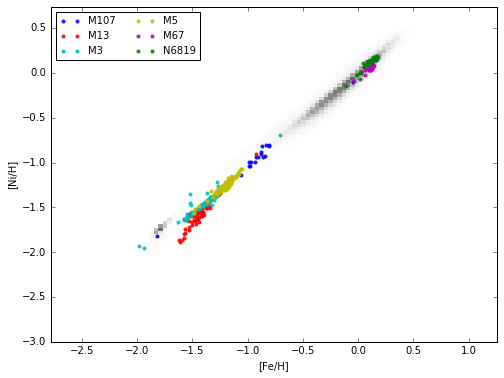

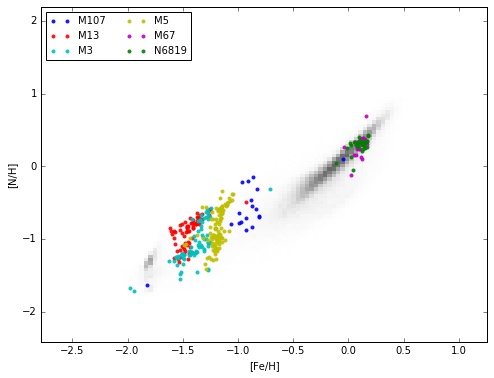

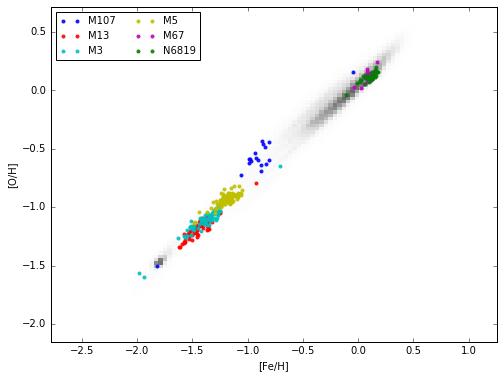

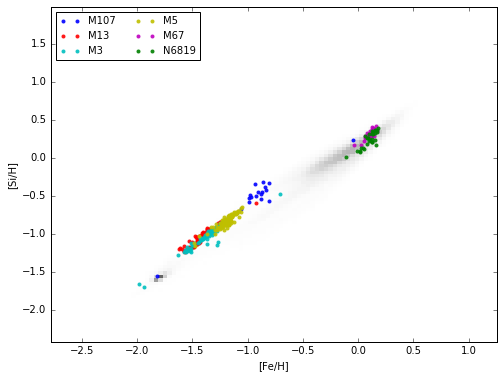

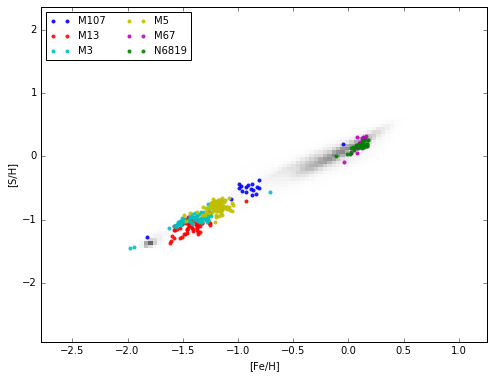

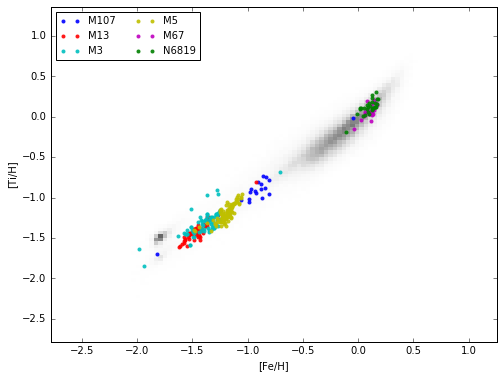

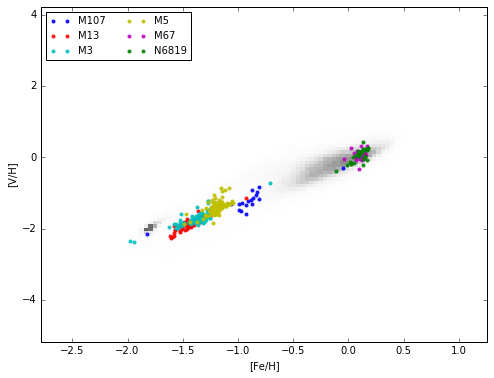

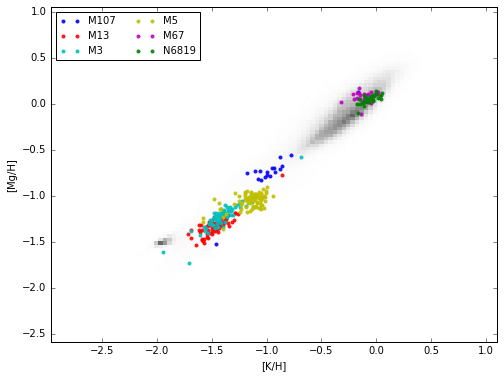

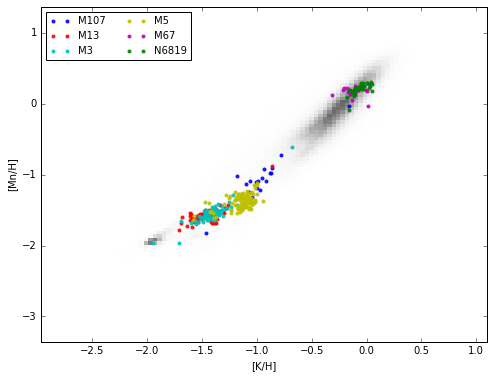

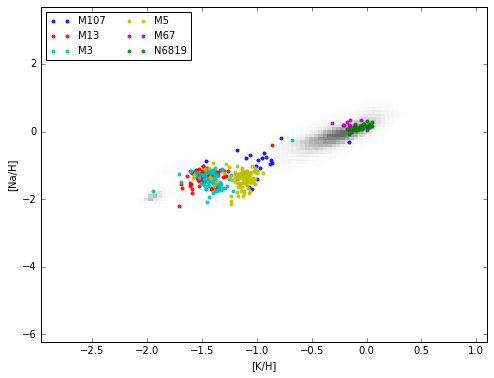

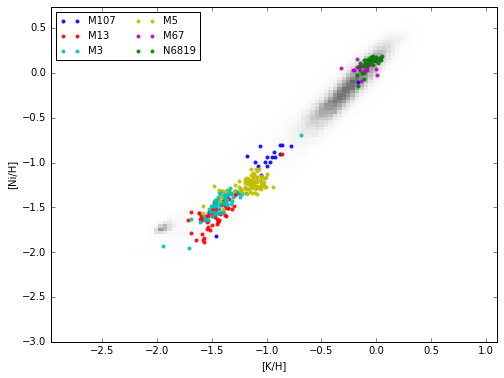

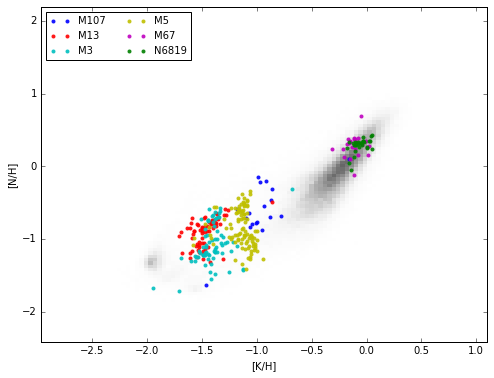

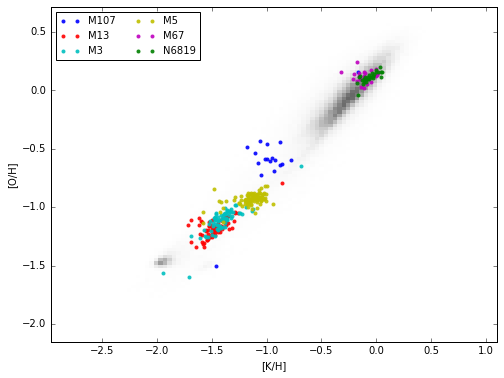

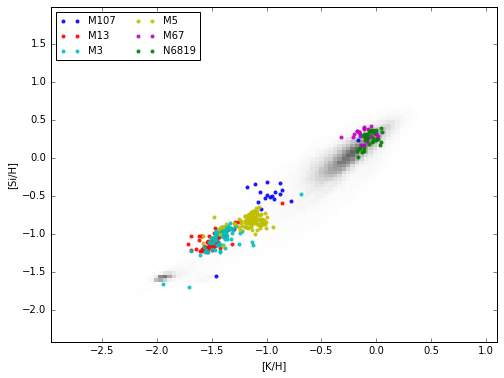

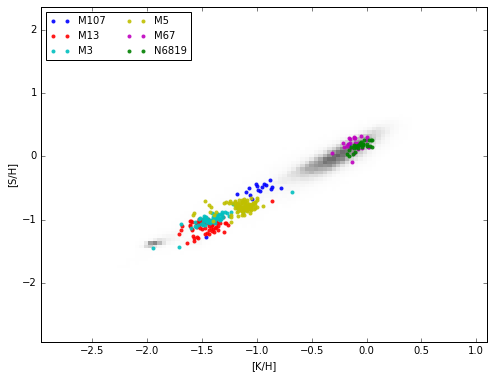

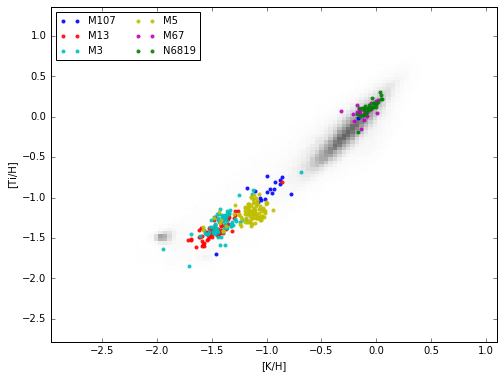

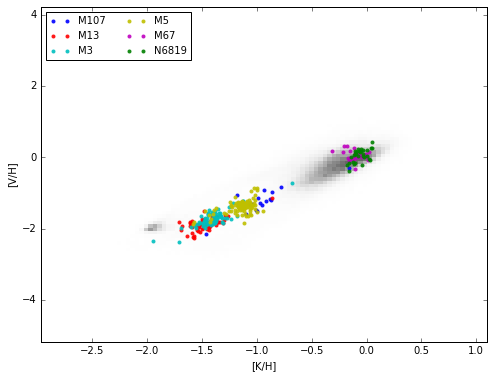

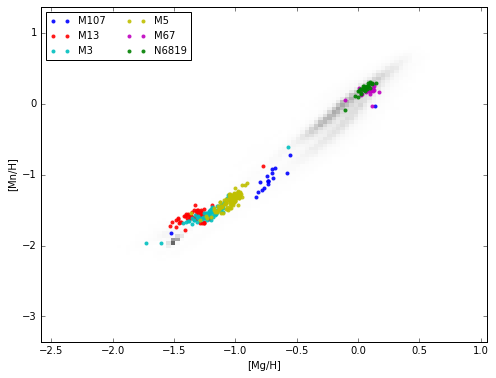

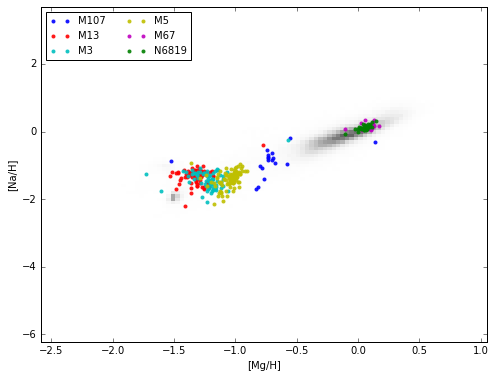

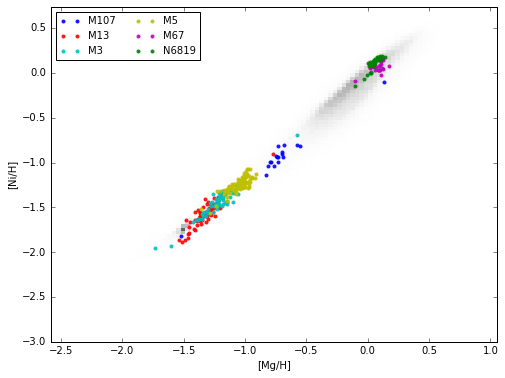

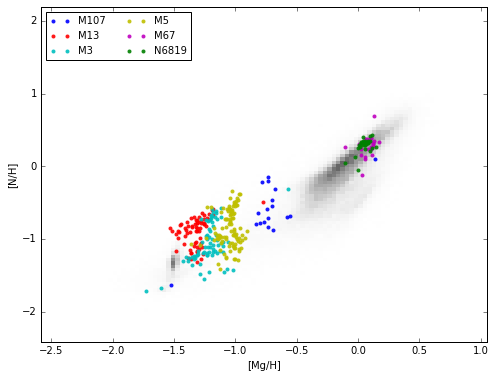

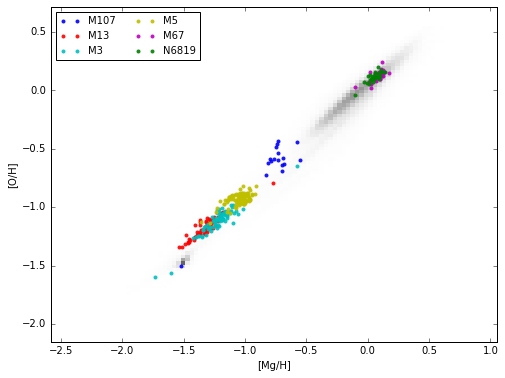

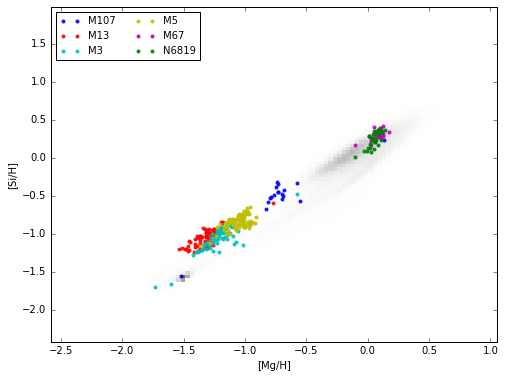

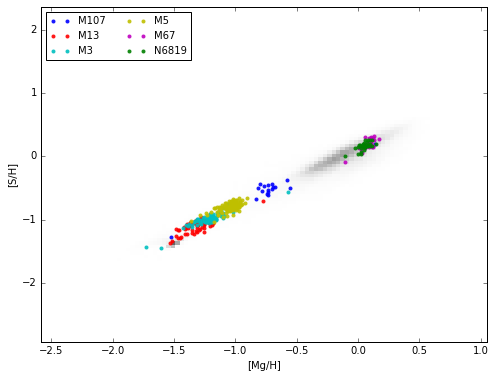

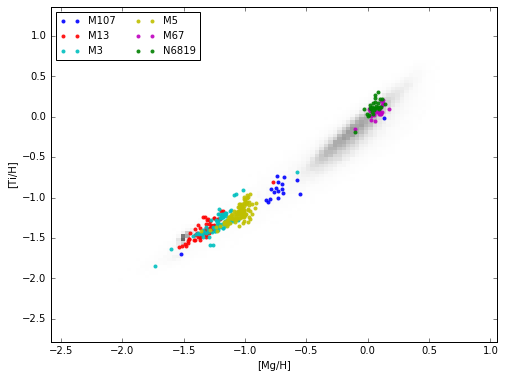

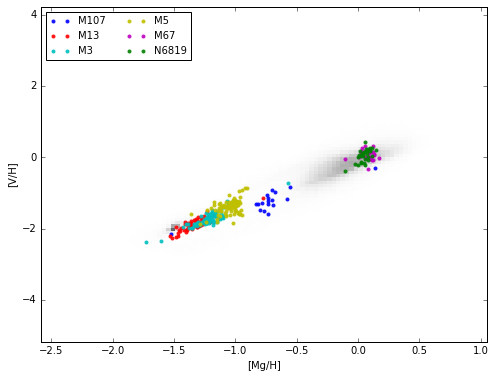

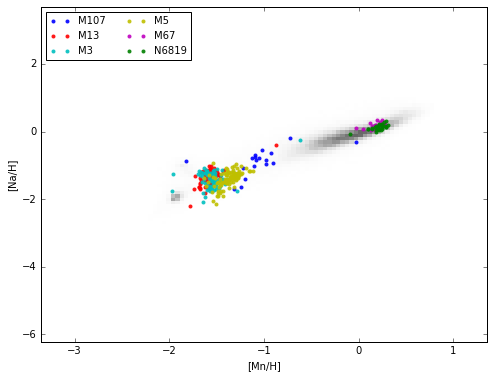

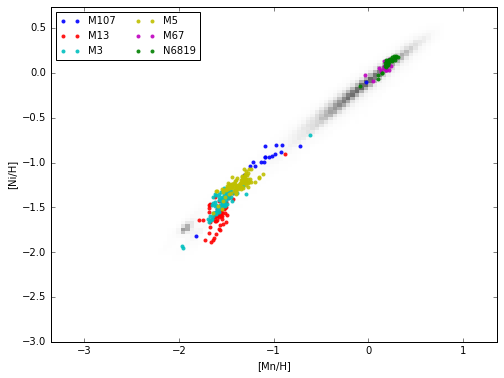

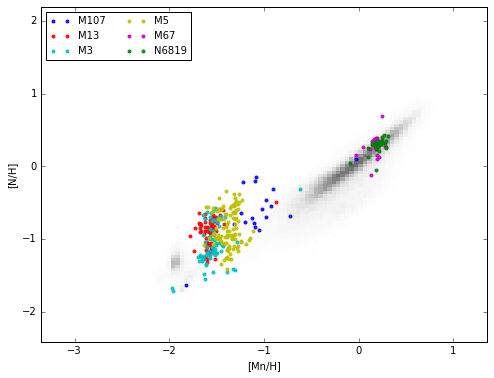

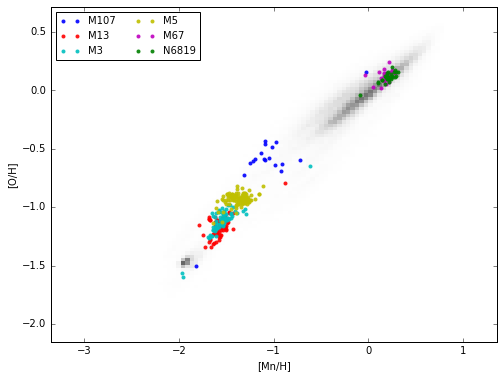

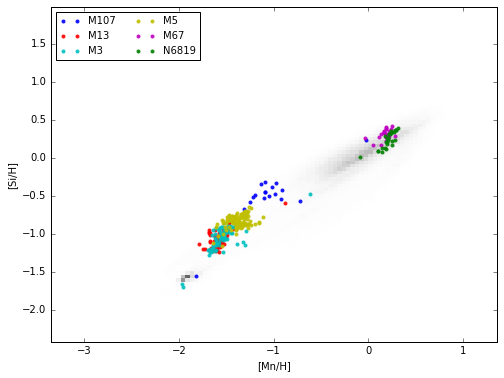

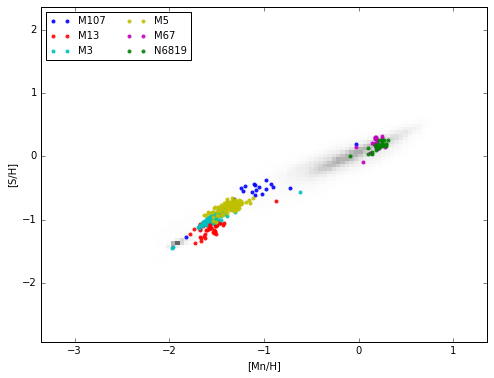

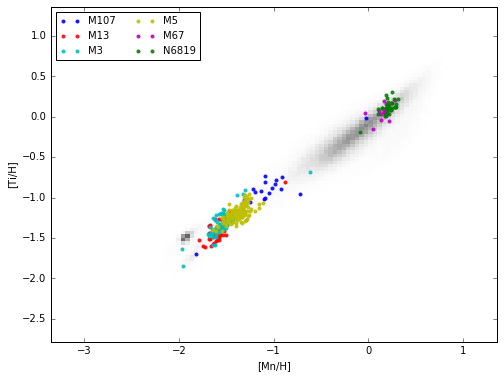

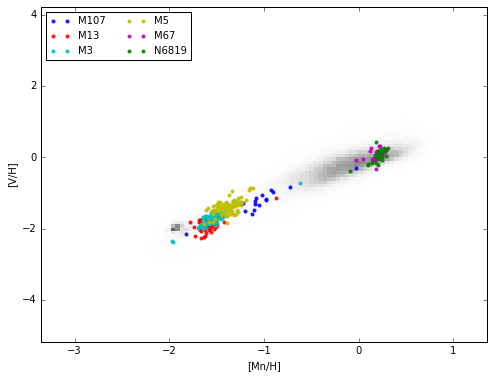

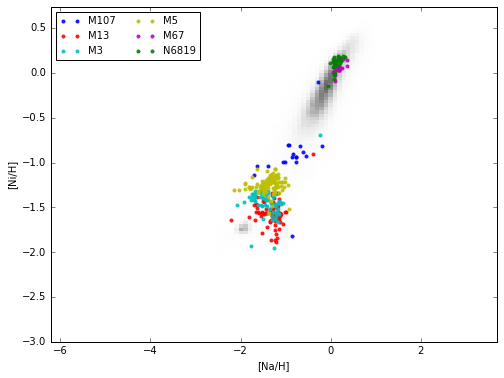

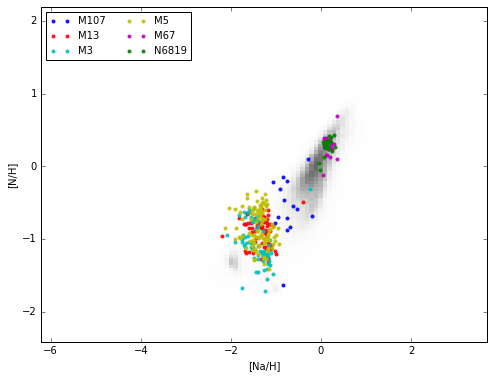

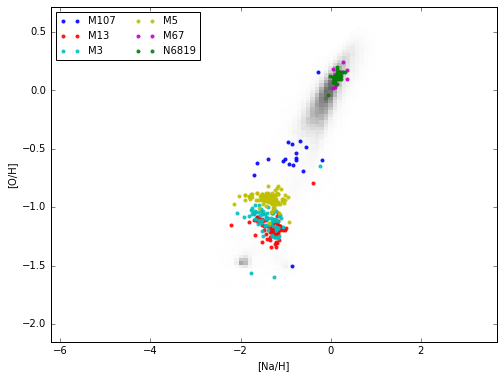

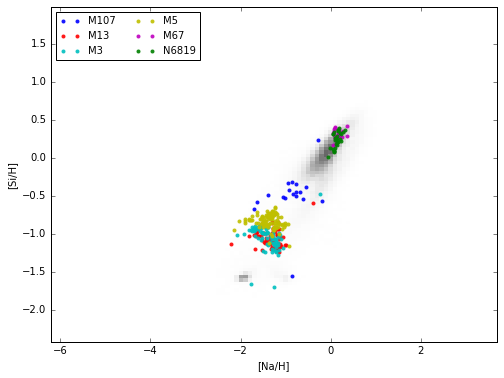

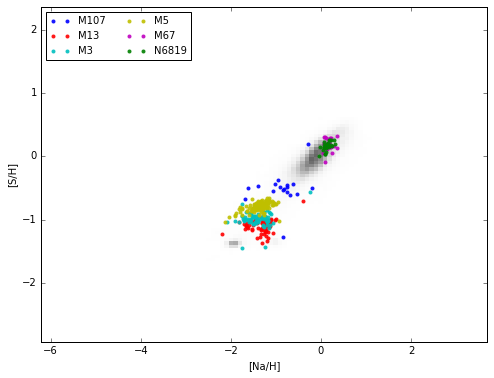

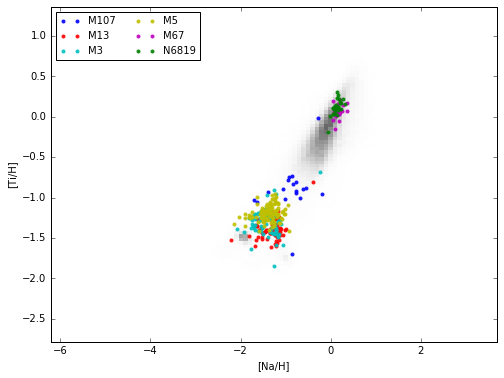

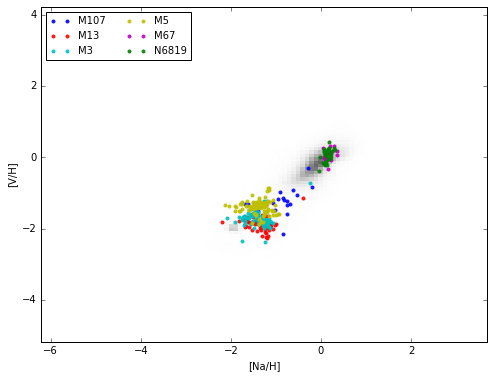

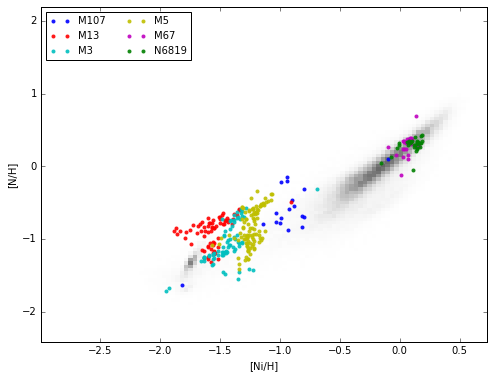

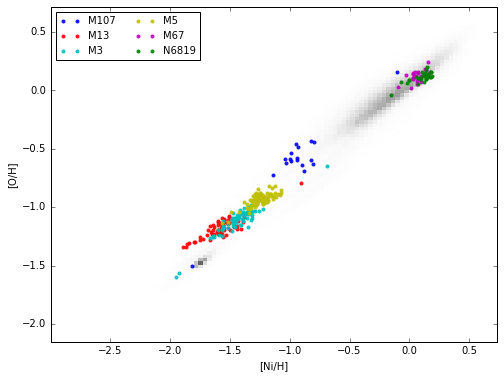

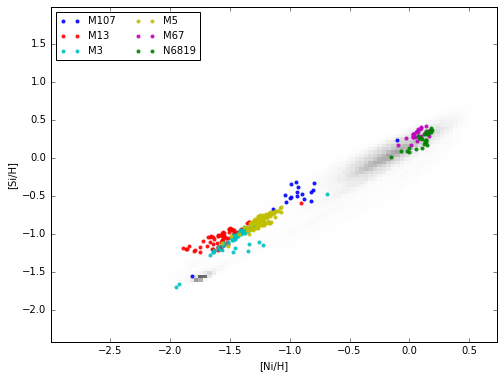

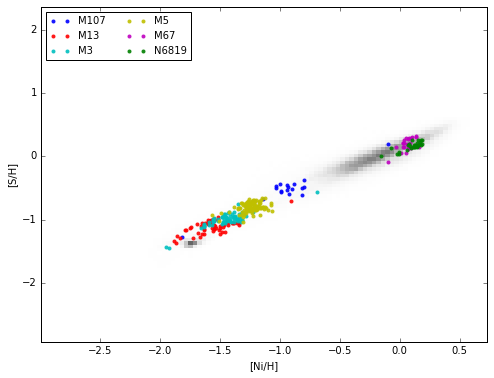

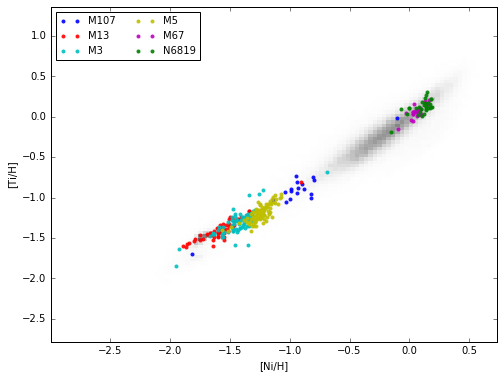

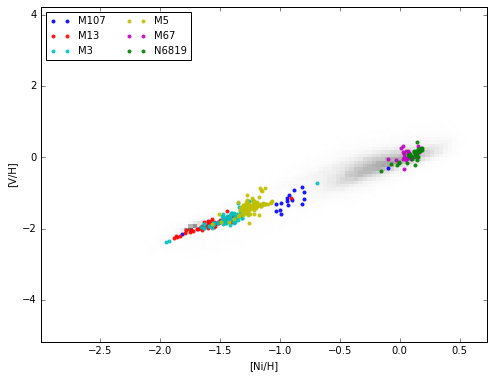

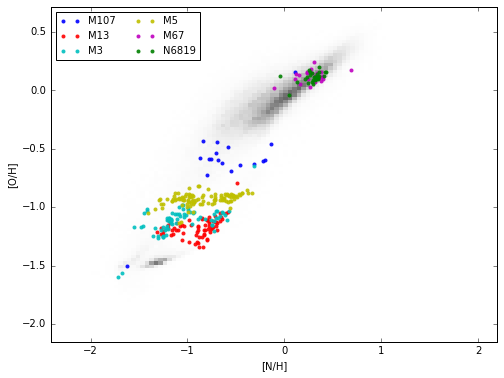

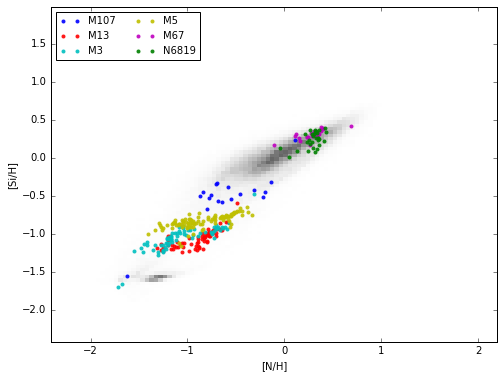

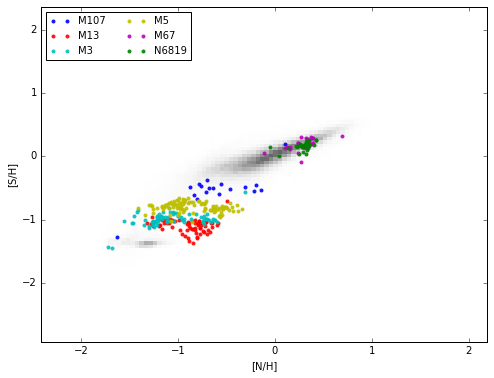

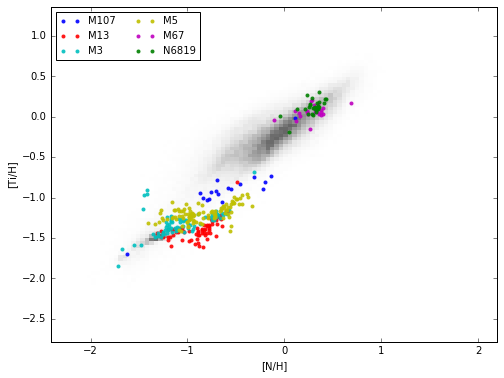

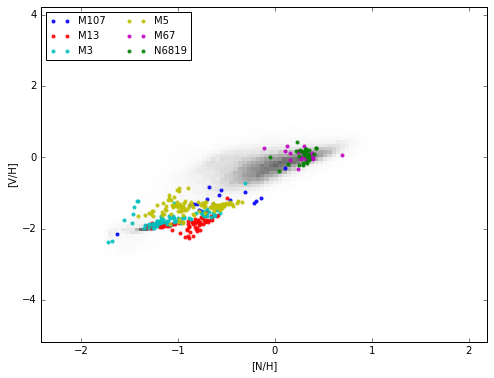

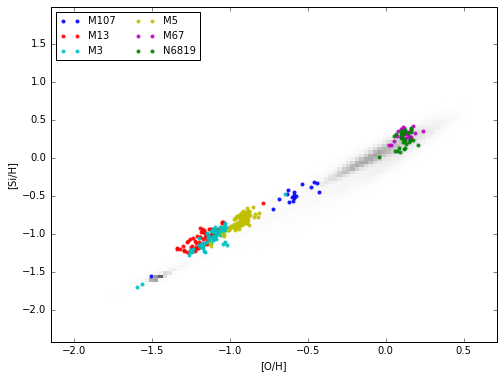

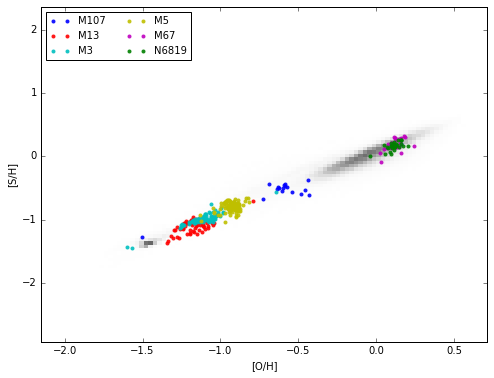

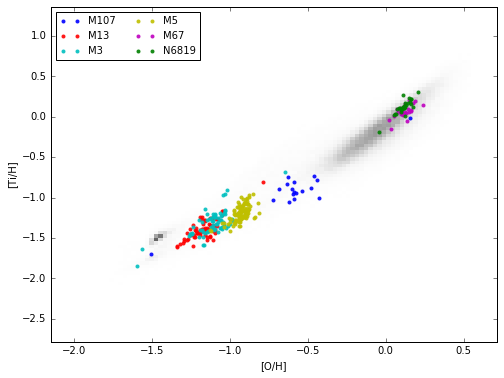

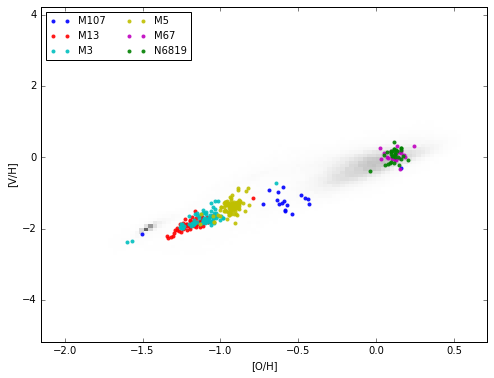

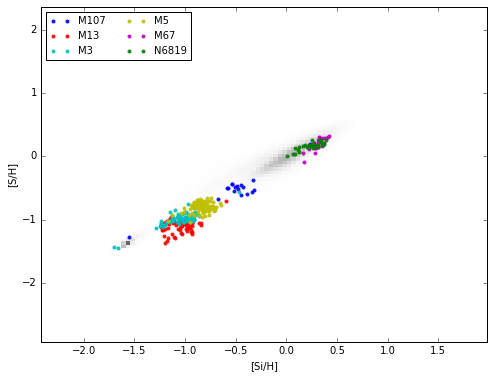

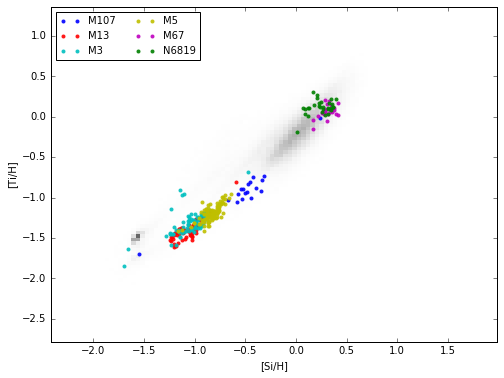

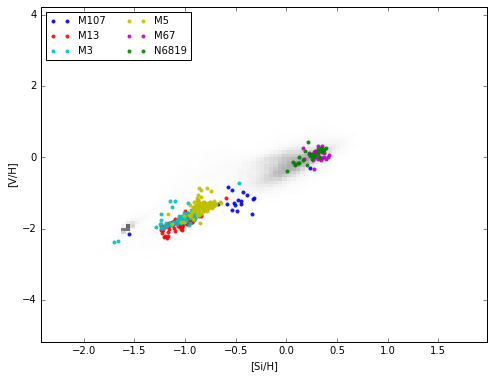

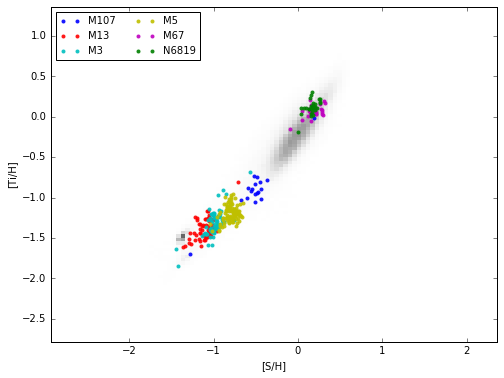

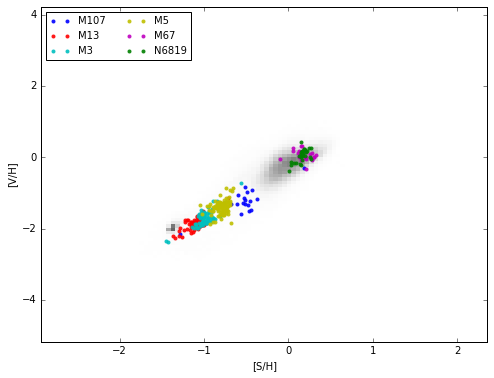

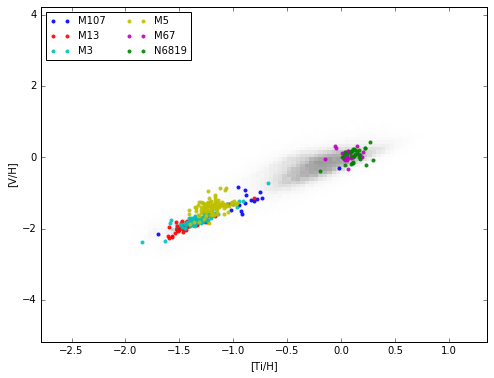

In [14]:
# plot clusters in chemical space with respect to H
colors = ['b', 'r', 'c', 'y', 'm', 'g']
for n in range(len(element_names)):
    for m in range(n+1, len(element_names)):
        fig = plt.figure(figsize=(8,6))
        plt.hist2d(ap_table_15[element_names[n]], ap_table_15[element_names[m]], bins=100, cmap='Greys', alpha=0.6)
        k = 0
        for group in ap_tb_check.groups:
            plt.plot(group[element_names[n]], group[element_names[m]], 'o', c=colors[k], 
                     mew=0, markersize=4, alpha=0.9, label=group['cluster_name'][0])
            k += 1
        plt.xlabel('[%s/H]' % elements[n])
        plt.ylabel('[%s/H]' % elements[m])
        plt.legend(loc=2, fontsize=10, ncol=2)
        plt.show()

We plot the six clusters in each element. The gray histogram shows the distribution of background stars. Each line represents the spread with one standard deviation of a cluster in the element. Different colors represent fidderent clusters. The results are similar to the ones above. 

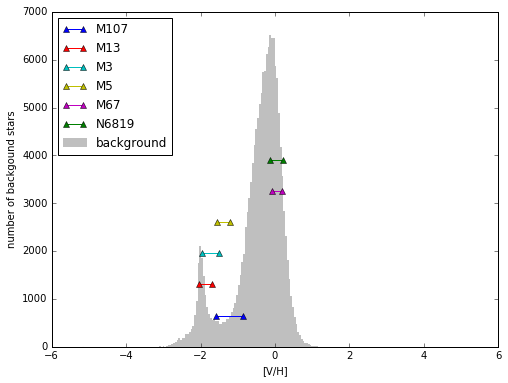

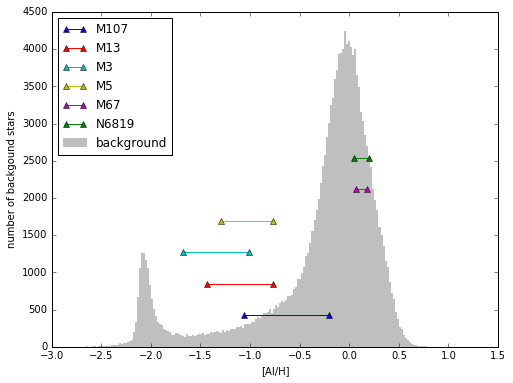

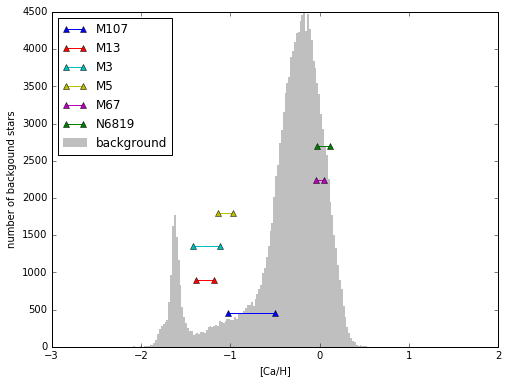

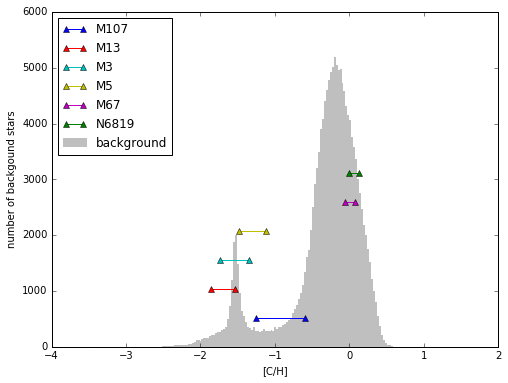

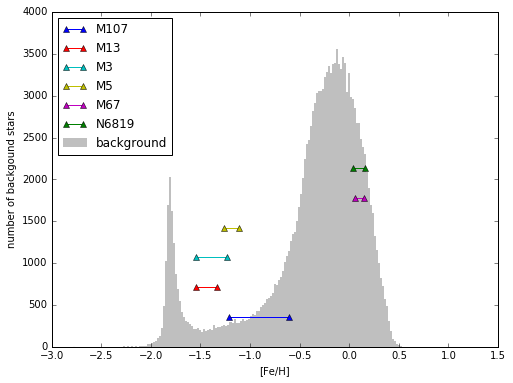

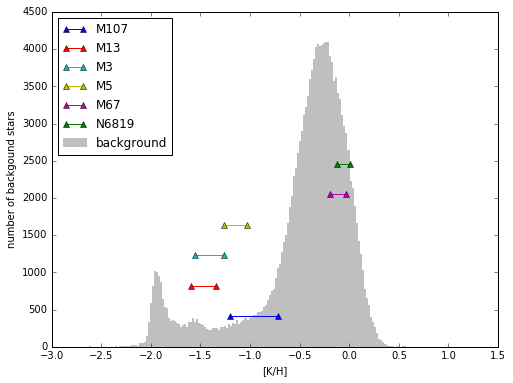

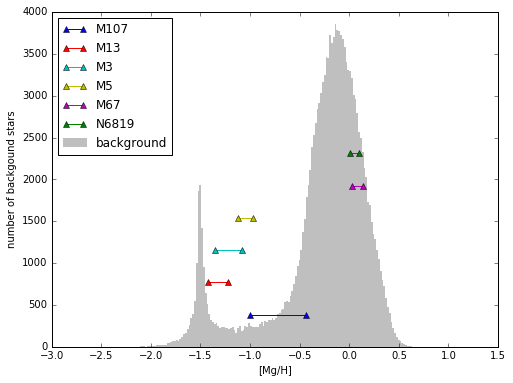

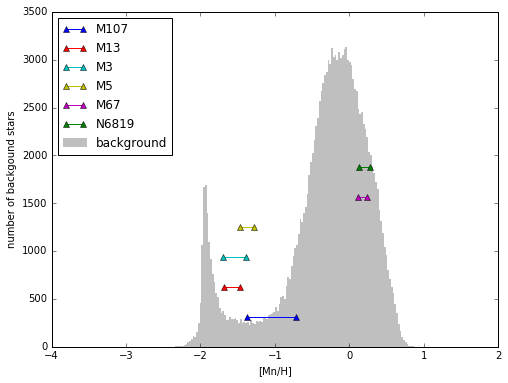

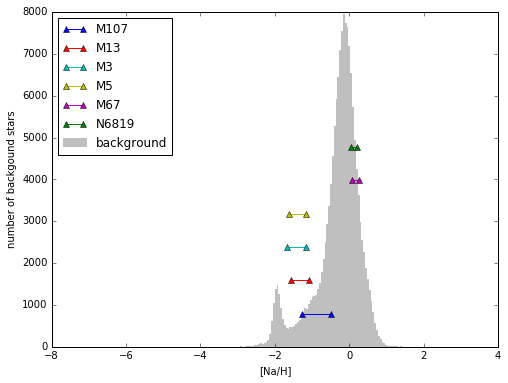

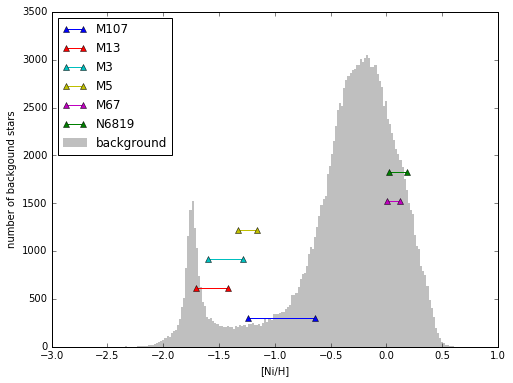

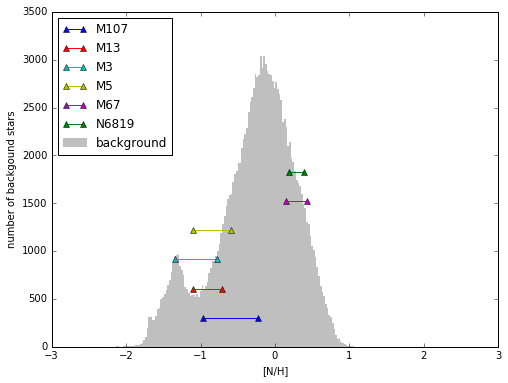

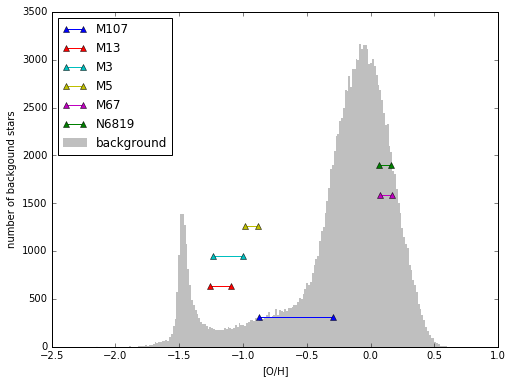

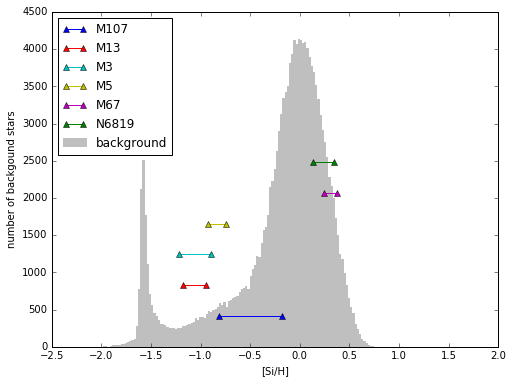

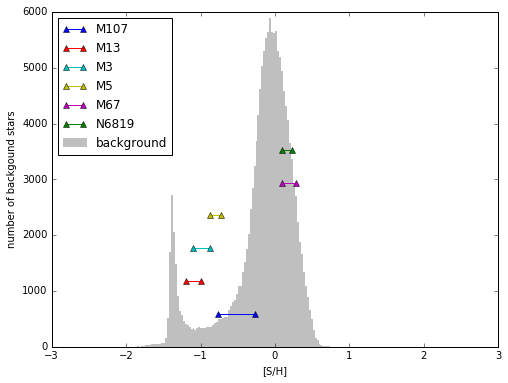

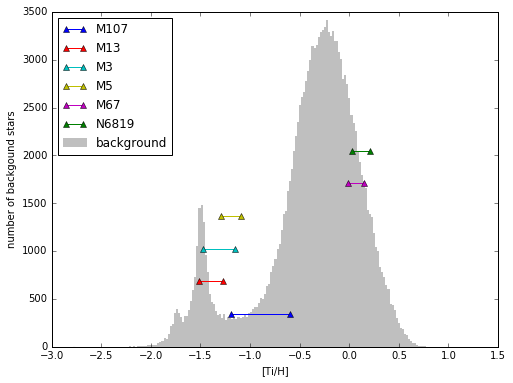

In [15]:
# plot clusters in chemical space with respect to H
colors = ['b', 'r', 'c', 'y', 'm', 'g']
for n in range(len(element_names)):
    fig = plt.figure(figsize=(8,6))
    H, bins, patches = plt.hist(ap_table_15[element_names[n-1]], bins=200, lw=0, color='grey', alpha=0.5, label='background')
    k = 0
    for group in ap_tb_check.groups:
        mean = np.mean(group[element_names[n-1]])
        std = np.std(group[element_names[n-1]])
        plt.plot([mean-std, mean+std], [(k + 1.)/10.*max(H) for i in range(2)], '^-', color=colors[k],
                 label=group['cluster_name'][0])
        k += 1
    plt.ylabel('number of backgound stars')
    plt.xlabel('[%s/H]' % elements[n-1])
    plt.legend(loc='upper left')
    plt.show()

## [X/Fe]
Instead of [X/H], we repeat the analysis using [X/Fe]. The clusters are harder to separate in [X/Fe].

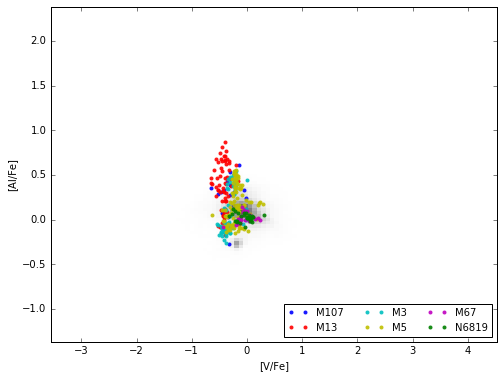

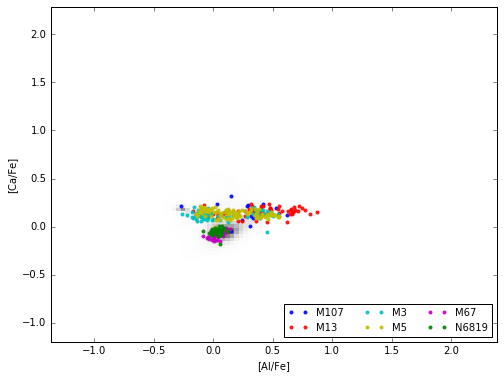

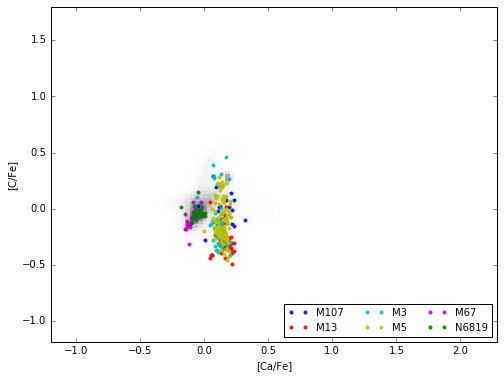

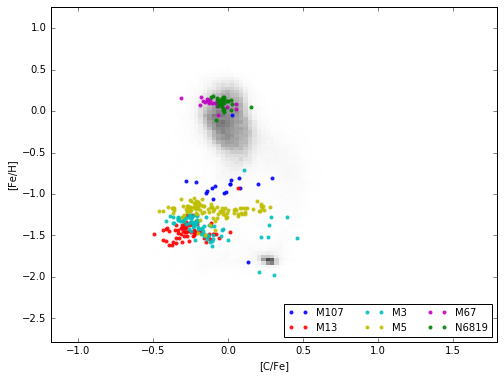

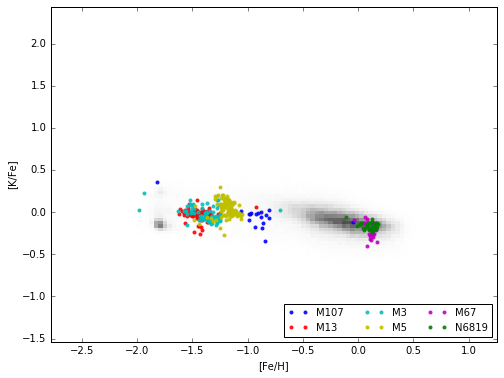

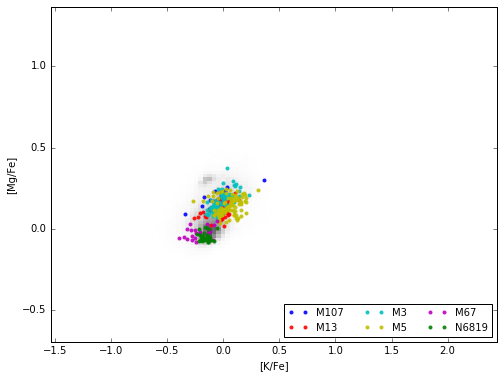

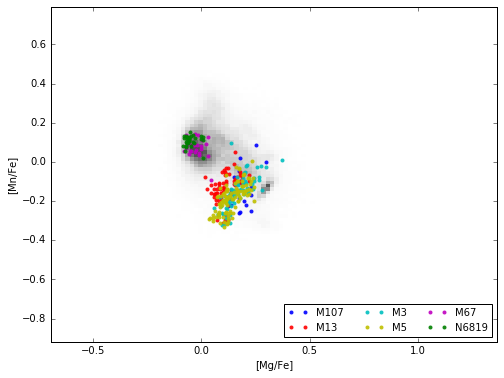

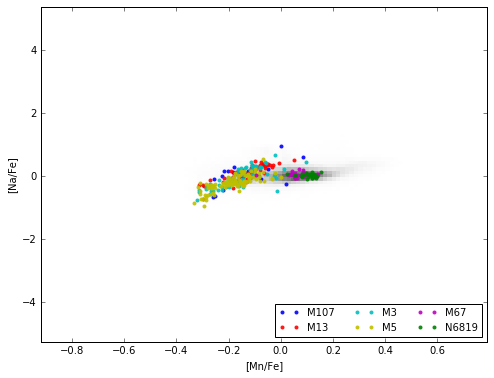

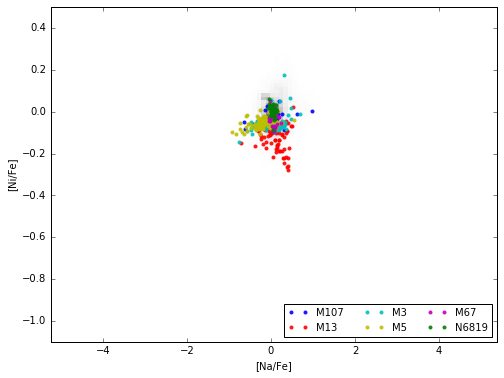

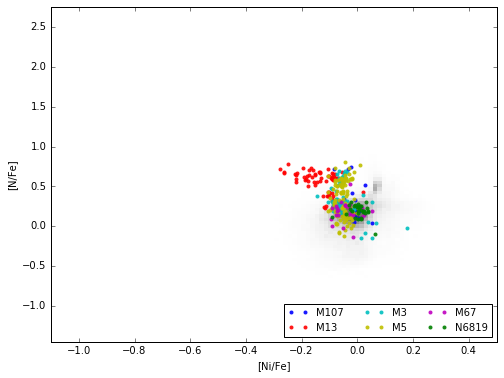

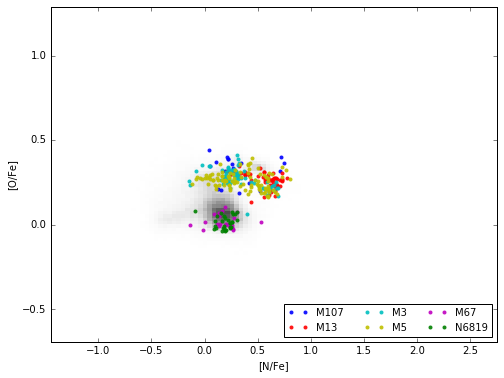

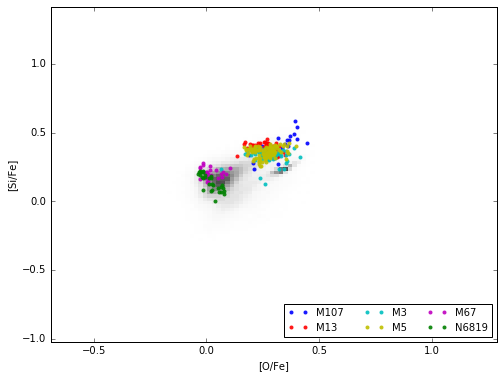

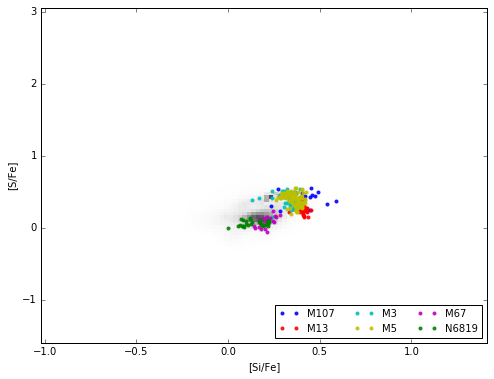

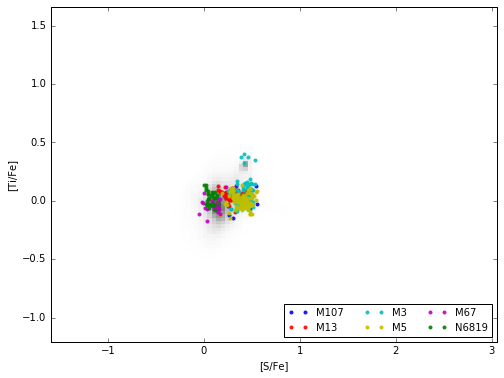

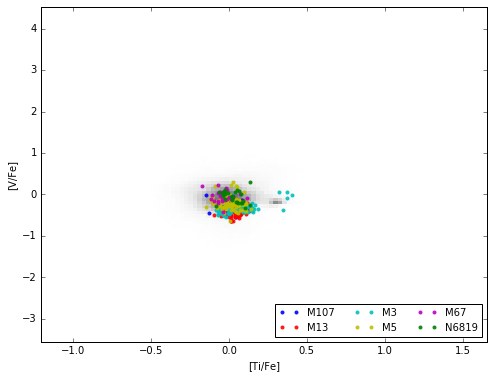

In [16]:
# plot clusters in chemical space with respect to Fe
cluster_labels = np.zeros(len(ap_tb_check))
for n in ap_tb_check.groups.indices[1:]:
    cluster_labels[n:] += 1
cluster_labels = cluster_labels.astype('int')
for n in range(len(element_names)):
    if (element_names[n-1] != 'FE_H') * (element_names[n] != 'FE_H'):
        fig = plt.figure(figsize=(8,6))
        plt.hist2d(ap_table_15[element_names[n-1]]-ap_table_15['FE_H'], ap_table_15[element_names[n]]-ap_table_15['FE_H'], 
                   bins=100, cmap='Greys', alpha=0.7)
        k = 0
        for group in ap_tb_check.groups:
            plt.plot(group[element_names[n-1]]-group['FE_H'], group[element_names[n]]-group['FE_H'], 'o', c=colors[k], 
                     mew=0, markersize=4, alpha=0.9, label=group['cluster_name'][0])
            k += 1
        plt.xlabel('[%s/Fe]' % elements[n-1])
        plt.ylabel('[%s/Fe]' % elements[n])
        plt.legend(loc=4, fontsize=10, ncol=3)
        plt.show()
    elif (element_names[n-1] != 'FE_H'):
        fig = plt.figure(figsize=(8,6))
        plt.hist2d(ap_table_15[element_names[n-1]]-ap_table_15['FE_H'], ap_table_15[element_names[n]], 
                   bins=100, cmap='Greys', alpha=0.7)
        k = 0
        for group in ap_tb_check.groups:
            plt.plot(group[element_names[n-1]]-group['FE_H'], group[element_names[n]], 'o', c=colors[k], 
                     mew=0, markersize=4, alpha=0.9, label=group['cluster_name'][0])
            k += 1
        plt.xlabel('[%s/Fe]' % elements[n-1])
        plt.ylabel('[%s/H]' % elements[n])
        plt.legend(loc=4, fontsize=10, ncol=3)
        plt.show()
    elif (element_names[n] != 'FE_H'):
        fig = plt.figure(figsize=(8,6))
        plt.hist2d(ap_table_15[element_names[n-1]], ap_table_15[element_names[n]]-ap_table_15['FE_H'], 
                   bins=100, cmap='Greys', alpha=0.7)
        k = 0
        for group in ap_tb_check.groups:
            plt.plot(group[element_names[n-1]], group[element_names[n]]-group['FE_H'], 'o', c=colors[k], 
                     mew=0, markersize=4, alpha=0.9, label=group['cluster_name'][0])
            k += 1
        plt.xlabel('[%s/H]' % elements[n-1])
        plt.ylabel('[%s/Fe]' % elements[n])
        plt.legend(loc=4, fontsize=10, ncol=3)
        plt.show()

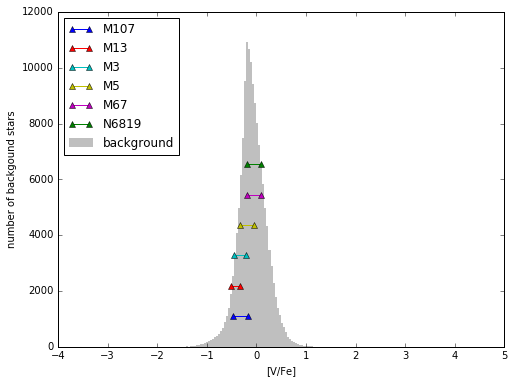

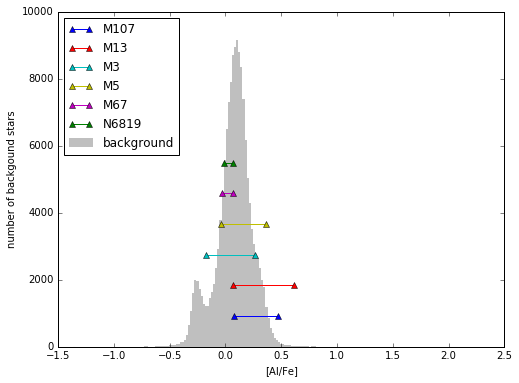

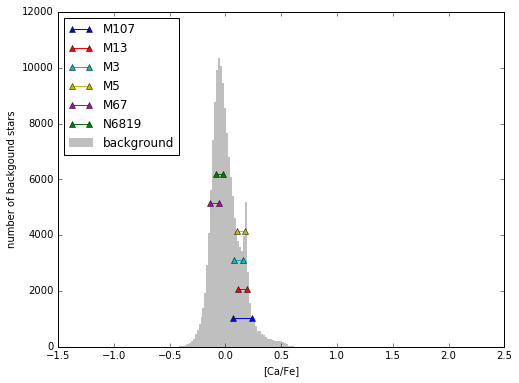

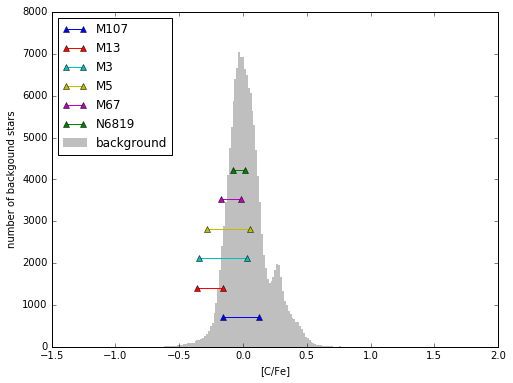

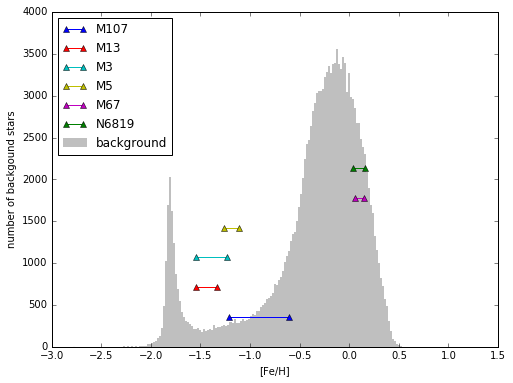

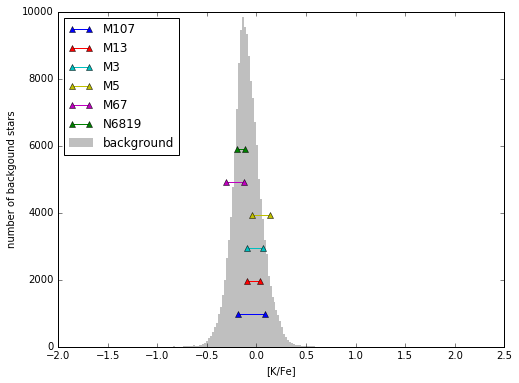

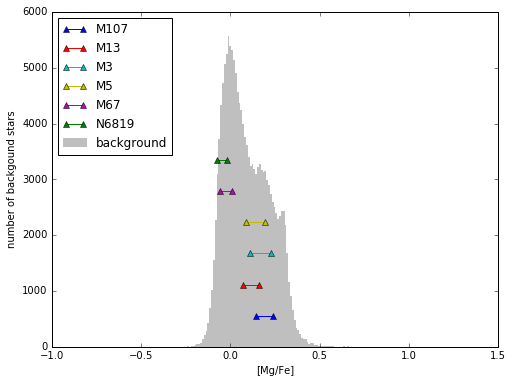

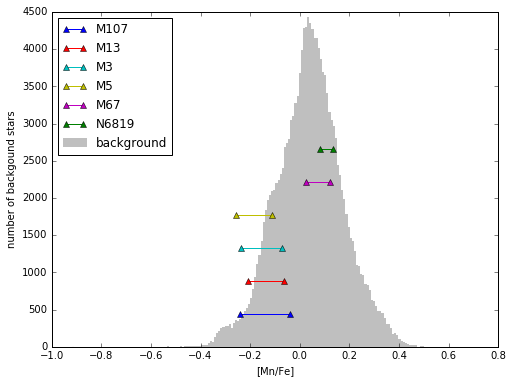

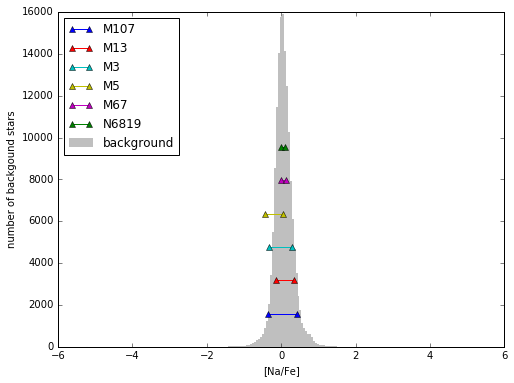

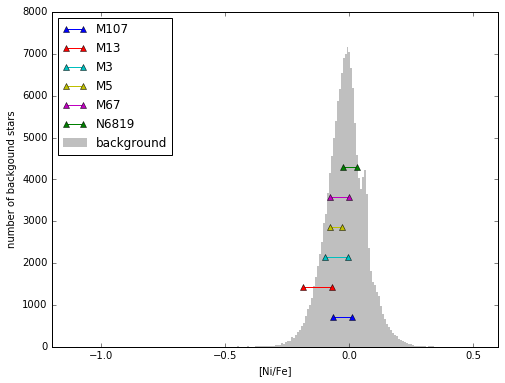

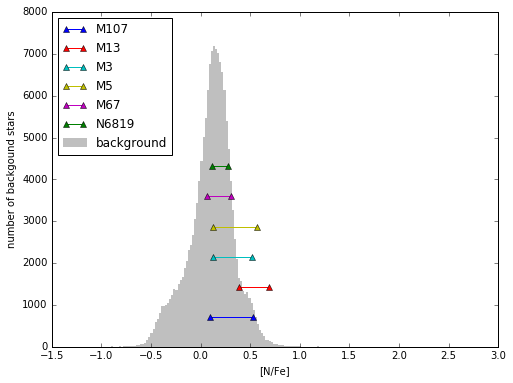

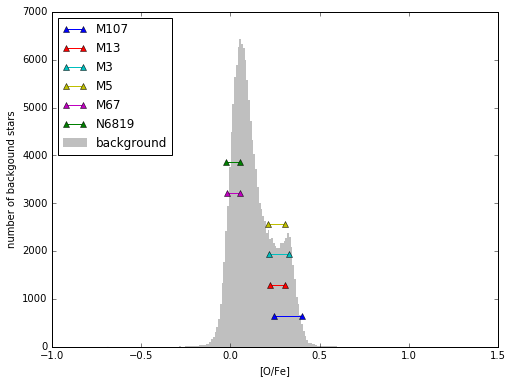

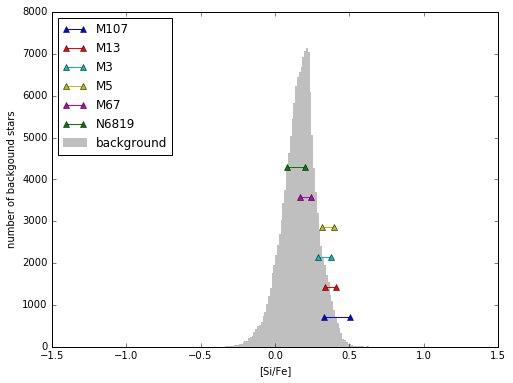

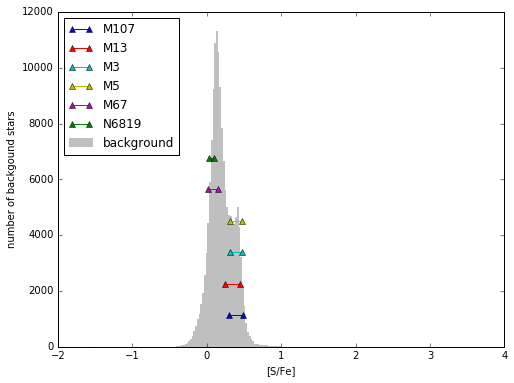

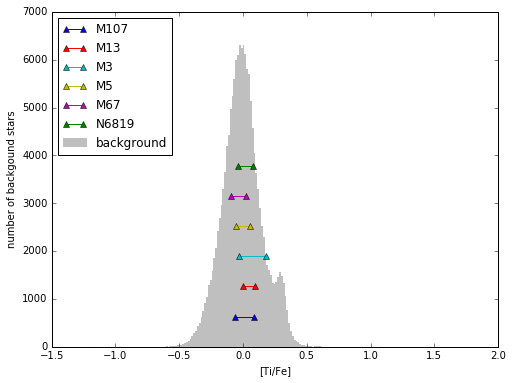

In [17]:
# plot clusters in chemical space with respect to H
colors = ['b', 'r', 'c', 'y', 'm', 'g']
for n in range(len(element_names)):
    if element_names[n-1] != 'FE_H':
        fig = plt.figure(figsize=(8,6))
        H, bins, patches = plt.hist(ap_table_15[element_names[n-1]]-ap_table_15['FE_H'], 
                                    bins=200, lw=0, color='grey', alpha=0.5, label='background')
        k = 0
        for group in ap_tb_check.groups:
            mean = np.mean(group[element_names[n-1]] - group['FE_H'])
            std = np.std(group[element_names[n-1]] - group['FE_H'])
            plt.plot([mean-std, mean+std], [(k + 1.)/10.*max(H) for i in range(2)], '^-', color=colors[k],
                     label=group['cluster_name'][0])
            k += 1
        plt.ylabel('number of backgound stars')
        plt.xlabel('[%s/Fe]' % elements[n-1])
        plt.legend(loc='upper left')
        plt.show()
    else: 
        fig = plt.figure(figsize=(8,6))
        H, bins, patches = plt.hist(ap_table_15[element_names[n-1]], bins=200, lw=0, color='grey', alpha=0.5, label='background')
        k = 0
        for group in ap_tb_check.groups:
            mean = np.mean(group[element_names[n-1]])
            std = np.std(group[element_names[n-1]])
            plt.plot([mean-std, mean+std], [(k + 1.)/10.*max(H) for i in range(2)], '^-', color=colors[k],
                     label=group['cluster_name'][0])
            k += 1
        plt.ylabel('number of backgound stars')
        plt.xlabel('[%s/H]' % elements[n-1])
        plt.legend(loc='upper left')
        plt.show()

## KMeans Clustering results

First, we apply KMeans to chemical abundances of 15 elements. All members of the six clusters are included. The v-measure-score of the result is 0.6325. M107 and M5 are recovered in their own KMeans group. However, M67 and N6819 occupy the same KMeans group. M3 and M13 are forced into three different KMeans groups.  

In [18]:
# perform KMeans on the chemical abundances of known clusters (15 elements)
# print cluster names in order
names_unique = []
for name in ap_tb_check['cluster_name']:
    if name not in names_unique:
        names_unique.append(name)
print names_unique
# get chemical abundances
ap_chem_kc = np.array([np.array(ap_tb_check[element_names][element], dtype=float) for element in element_names])
ap_chem_kc = ap_chem_kc.T
# compile true labels
ap_true_labels = np.array([])
k = 0
for group in ap_tb_check.groups:
    ap_true_labels = np.append(ap_true_labels, np.zeros(len(group)) + k)
    k += 1
print np.array(ap_true_labels, dtype=int)
num_kc = 6
kmeans = KMeans(num_kc)
kmeans.fit(ap_chem_kc)
labels = kmeans.labels_
print "v-measure-score is ", v_measure_score(labels, ap_true_labels)
print labels

['M107', 'M13', 'M3', 'M5', 'M67', 'N6819']
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
v-measure-score is  0.55252888341
[3 3 3 3 4 4 3 5 3 3 3 3 3 3 3 3 1 3 5 0 0 5 0 5 5 0 5 0 5 5 0 3 5 0 5 0 5
 0 5 4 0 0 0 4 0 0 5 5 0 0 0 5 5 0 5 0 5 5 0 5 0 0 0 0 5 0 0 5 0 0 5 5 0 0
 0 0 5 0 0 5 5 5 0 5 0 5 5 5 0 2 0 0 2 5 0 5 5 0 0 5 5 3 0 0 5 0 4 0 4 5 0
 5 5 5 5 5 2 5 5 2 5 5 0 0 5 0 0 5 5 5 5 0 0 0 0 

In [19]:
# perform KMeans on the chemical abundances of known clusters (10 elements)
# print cluster names in order
print names_unique
# get chemical abundances
ap_chem_kc = np.array([np.array(ap_tb_check[element_names][element], dtype=float) for element in element_names_10])
ap_chem_kc = ap_chem_kc.T
# compile true labels
ap_true_labels = np.array([])
k = 0
for group in ap_tb_check.groups:
    ap_true_labels = np.append(ap_true_labels, np.zeros(len(group)) + k)
    k += 1
print np.array(ap_true_labels, dtype=int)
num_kc = 6
kmeans = KMeans(num_kc)
kmeans.fit(ap_chem_kc)
labels = kmeans.labels_
print "v-measure-score is ", v_measure_score(labels, ap_true_labels)
print labels

['M107', 'M13', 'M3', 'M5', 'M67', 'N6819']
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
v-measure-score is  0.605263957941
[3 3 3 3 3 4 3 2 3 3 3 3 3 3 3 3 1 3 2 0 0 2 0 2 2 0 2 0 2 2 0 3 2 0 2 0 2
 0 2 0 0 0 0 0 0 0 2 2 0 0 0 2 2 0 2 0 2 2 0 2 0 0 0 0 2 0 0 2 0 2 2 2 0 0
 0 0 2 0 0 2 2 2 0 2 0 2 2 2 0 5 5 0 5 2 0 2 5 0 0 2 2 3 2 5 2 0 0 5 0 2 0
 2 2 2 2 2 5 2 2 5 2 2 0 5 2 0 0 2 2 2 2 0 5 0 5

In [20]:
# perform KMeans on the chemical abundances of known clusters ([X/Fe], 15 elements)
# print cluster names in order
print names_unique
# get chemical abundances
ap_chem_kc = []
for n in range(len(element_names)):
    if element_names[n] != 'FE_H':
        ap_chem_kc.append(np.array(ap_tb_check[element_names[n]] - ap_tb_check['FE_H'], dtype=float))
    else: 
        ap_chem_kc.append(np.array(ap_tb_check[element_names[n]], dtype=float))
ap_chem_kc = np.array(ap_chem_kc)
ap_chem_kc = ap_chem_kc.T
# compile true labels
ap_true_labels = np.array([])
k = 0
for group in ap_tb_check.groups:
    ap_true_labels = np.append(ap_true_labels, np.zeros(len(group)) + k)
    k += 1
print np.array(ap_true_labels, dtype=int)
num_kc = 6
kmeans = KMeans(num_kc)
kmeans.fit(ap_chem_kc)
labels = kmeans.labels_
print "v-measure-score is ", v_measure_score(labels, ap_true_labels)
print labels

['M107', 'M13', 'M3', 'M5', 'M67', 'N6819']
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
v-measure-score is  0.422857825382
[5 5 4 5 4 4 0 1 0 5 0 0 5 5 5 5 2 0 1 3 3 3 3 1 3 3 1 3 1 3 3 5 1 3 4 0 1
 0 1 3 3 0 0 3 0 0 1 1 3 0 3 4 1 3 4 3 3 3 0 4 3 3 0 3 3 3 3 4 0 0 3 3 3 3
 3 0 1 3 3 1 1 1 3 1 3 1 1 1 3 4 4 1 5 1 0 1 4 0 0 1 1 5 4 1 5 0 0 4 0 1 0
 4 1 1 1 1 5 1 1 5 1 1 0 4 4 0 0 1 1 1 1 0 4 0 4

In [21]:
# perform KMeans on the chemical abundances of known clusters ([X/Fe], 10 elements)
# print cluster names in order
print names_unique
# get chemical abundances
ap_chem_kc = []
for n in range(len(element_names_10)):
    if element_names[n] != 'FE_H':
        ap_chem_kc.append(np.array(ap_tb_check[element_names_10[n]] - ap_tb_check['FE_H'], dtype=float))
    else: 
        ap_chem_kc.append(np.array(ap_tb_check[element_names_10[n]], dtype=float))
ap_chem_kc = np.array(ap_chem_kc)
ap_chem_kc = ap_chem_kc.T
# compile true labels
ap_true_labels = np.array([])
k = 0
for group in ap_tb_check.groups:
    ap_true_labels = np.append(ap_true_labels, np.zeros(len(group)) + k)
    k += 1
print np.array(ap_true_labels, dtype=int)
num_kc = 6
kmeans = KMeans(num_kc)
kmeans.fit(ap_chem_kc)
labels = kmeans.labels_
print "v-measure-score is ", v_measure_score(labels, ap_true_labels)
print labels

['M107', 'M13', 'M3', 'M5', 'M67', 'N6819']
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
v-measure-score is  0.539024648103
[5 5 5 5 1 1 5 3 5 5 5 5 5 5 5 1 2 5 3 0 4 0 4 3 0 4 3 4 3 0 0 5 3 4 3 0 3
 0 3 4 0 0 0 4 0 0 3 3 4 0 0 3 3 0 3 0 0 0 0 3 4 4 0 4 0 4 4 3 0 0 4 0 4 0
 4 0 3 4 4 3 0 3 0 3 4 3 3 1 4 1 3 3 1 3 0 3 3 0 3 3 3 5 3 3 3 0 0 3 0 3 0
 3 3 3 3 3 1 3 3 1 3 3 0 3 3 0 0 3 3 3 3 0 3 0 3

## Chemically Similar Stars vs. Members

In [22]:
def similar_table(num_std): 
    colors = ['b', 'r', 'c', 'y', 'm', 'g']
    k = 0
    nums_member = []
    nums_similar = []
    nums_overlap = []
    similar_table_names = ['cluster name', 'members', 'chemically similar stars', 
                           'chemically similar members']
    # iterate through each cluster
    for group in ap_tb_check.groups:
        # get chemical abundance of the cluster
        ap_chem_cl = np.array([np.array(group[element], dtype=float) for element in element_names])
        ap_chem_cl = ap_chem_cl.T
        # store mean and error for each element
        ap_chem_mean = np.zeros(len(ap_chem_cl[0]))
        ap_chem_error = np.zeros(len(ap_chem_cl[0]))
        # iterate through each element
        for n in range(len(ap_chem_cl[0])):
            # get mean and error of the element
            ap_chem_mean[n] = np.mean(ap_chem_cl[:,n])
            ap_chem_error[n] = np.std(ap_chem_cl[:,n])
        print group['cluster_name'][0]
        print Table([elements, ap_chem_error], 
                          names=['element', 'spread'], meta={'name': 'error table'})
        # a list of indexes for all stars with 15 elements
        similar = np.arange(len(ap_table_15))
        # iterate through each element
        for m in range(len(element_names_10)):
            # get chemically similar stars with 10 elements
            select = np.where(np.abs(ap_table_15[element_names[m]] - ap_chem_mean[m]) < ap_chem_error[m] * num_std)[0]
            similar = np.intersect1d(similar, select)
        # get overlap between chemically similar stars and members
        overlap = np.intersect1d(group['APOGEE_ID'], ap_table_15[similar]['APOGEE_ID'])
        # store the numbers 
        nums_member.append(len(group))
        nums_similar.append(len(similar))
        nums_overlap.append(len(overlap))
    #     print group['cluster_name'][0], len(group), len(similar), len(overlap)
        k += 1
    # get cluster names
    names = [ap_tb_check.groups.keys[n][0] for n in range(len(ap_tb_check.groups.keys))]
    # convert to numpy array and set data type
    nums_member = np.array(nums_member, dtype=int)
    nums_similar = np.array(nums_similar, dtype=int)
    nums_overlap = np.array(nums_overlap, dtype=int)
    # create a table
    similar_table = Table([names, nums_member, nums_similar, nums_overlap], 
                          names=similar_table_names, meta={'name': 'percentage table'})
    # print table
    print similar_table

In [23]:
similar_table(1.)
similar_table(2.)
similar_table(3.)

M107
element     spread    
------- --------------
     Al 0.426966709274
     Ca 0.261914432176
      C  0.32561260431
     Fe 0.303448982092
      K 0.241115065706
     Mg  0.28470297767
     Mn  0.33069006335
     Na 0.381131334431
     Ni 0.299209192361
      N 0.368234272161
      O 0.289625482221
     Si 0.316565902918
      S 0.254297845242
     Ti 0.294738410286
      V 0.362872814111
M13
element      spread    
------- ---------------
     Al  0.334482957696
     Ca  0.102127473006
      C  0.163850829659
     Fe  0.102936599998
      K  0.123154524025
     Mg  0.102212804535
     Mn  0.108048623247
     Na  0.236463621367
     Ni  0.142782674729
      N  0.194600884157
      O 0.0823622693013
     Si  0.116001886869
      S 0.0997524073131
     Ti  0.121864115139
      V  0.169800558076
M3
element     spread    
------- --------------
     Al 0.330592885194
     Ca  0.15199567308
      C 0.196999102616
     Fe 0.157438792952
      K 0.148978933933
     Mg 0.134874195295
     

In [24]:
# retrieve chemically similar stars with Bovy's numbers


## Logg and Teff

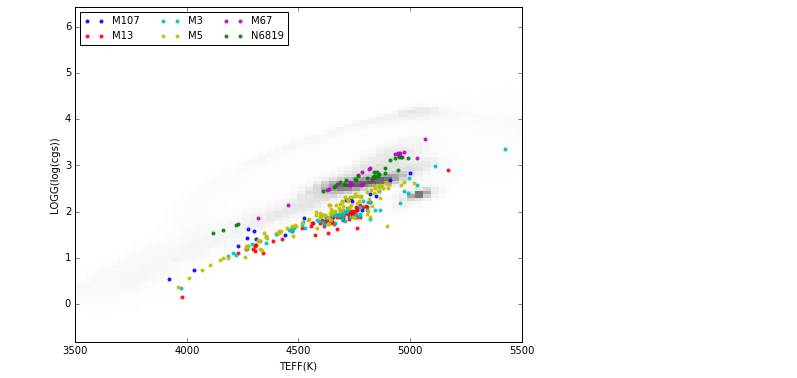

In [25]:
# plot log_g and Teff
fig = plt.figure(figsize=(8,6))
plt.hist2d(ap_table_15['TEFF'], ap_table_15['LOGG'], 
                   bins=100, cmap='Greys', alpha=0.7)
k = 0
for group in ap_tb_check.groups:
    plt.plot(group['TEFF'], group['LOGG'], 'o', c=colors[k], 
             mew=0, markersize=4, alpha=0.9, label=group['cluster_name'][0])
    k += 1
plt.xlabel('TEFF(K)')
plt.ylabel('LOGG(log(cgs))')
plt.xlim(3500, 5500)
plt.legend(loc=2, fontsize=10, ncol=3)
plt.show()

## GLON and Radial Velocity

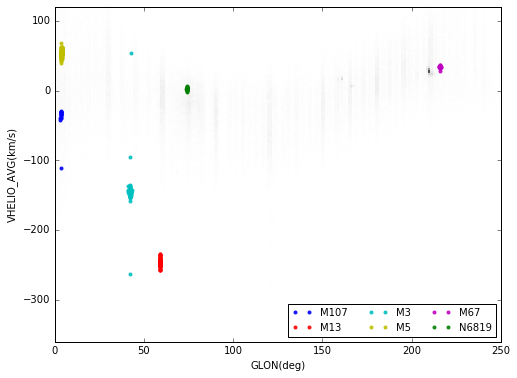

In [26]:
# plot GLON and VHELIO_AVG
fig = plt.figure(figsize=(8,6))
plt.hist2d(ap_table_15['GLON'], ap_table_15['VHELIO_AVG'], bins=200, range=[[0,250], [-360,120]], cmap='Greys', alpha=0.7)
k = 0
for group in ap_tb_check.groups:
    plt.plot(group['GLON'], group['VHELIO_AVG'], 'o', c=colors[k], 
             mew=0, markersize=4, alpha=0.9, label=group['cluster_name'][0])
    k += 1
plt.xlabel('GLON(deg)')
plt.ylabel('VHELIO_AVG(km/s)')
plt.xlim(0, 250)
plt.legend(loc=4, fontsize=10, ncol=3)
plt.show()

## Proper Motion

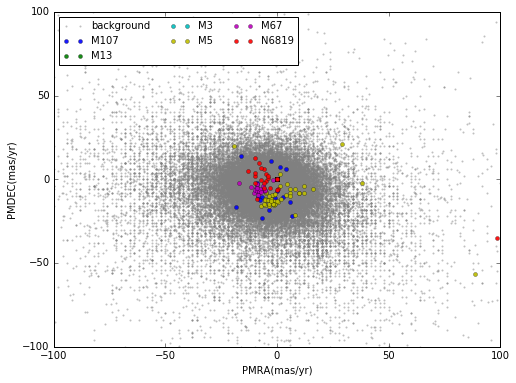

In [27]:
# plot proper motions
colors = ['b', 'g', 'c', 'y', 'm', 'r']
fig = plt.figure(figsize=(8,6))
# plot background
valid = np.where((ap_table_15['PMRA'] > -9999.0) * (ap_table_15['PMDEC'] > -9999.0))[0]
plt.plot(ap_table_15['PMRA'][valid], ap_table_15['PMDEC'][valid], 'o', c='grey', mew=0, markersize=2, alpha=0.5, 
         label='background')
# plot clusters
k = 0
for group in ap_tb_check.groups:
    valid = np.where((group['PMRA'] > -9999.0) * (group['PMDEC'] > -9999.0))[0]
    plt.plot(group['PMRA'][valid], group['PMDEC'][valid], 'o', c=colors[k], 
             mew=0.3, markersize=4, alpha=0.9, label=group['cluster_name'][0])
    k += 1
plt.xlabel('PMRA(mas/yr)')
plt.ylabel('PMDEC(mas/yr)')
plt.xlim(-100, 100)
plt.ylim(-100, 100)
plt.legend(loc=2, fontsize=10, ncol=3)
plt.show()

## Velocity
We plot the six clusters in radial velocity space. Each line represents the spread of a cluster with two standard deviations in velocity space. Different colors represent different clusters. The six clusters are well separated. 

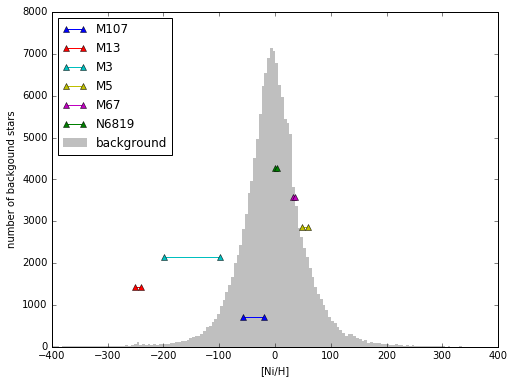

In [37]:
# plot clusters in chemical space with respect to H
colors = ['b', 'r', 'c', 'y', 'm', 'g']
fig = plt.figure(figsize=(8,6))
valid = np.where(ap_table_15['VHELIO_AVG'] < 999999.)[0]
H, bins, patches = plt.hist(ap_table_15['VHELIO_AVG'][valid], bins=500, lw=0, color='grey', alpha=0.5, label='background')
k = 0
for group in ap_tb_check.groups:
    valid = np.where(group['VHELIO_AVG'] < 999999.)[0]
    mean = np.mean(group['VHELIO_AVG'][valid])
    std = np.std(group['VHELIO_AVG'][valid])
    plt.plot([mean-std, mean+std], [(k + 1.)/10.*max(H) for i in range(2)], '^-', color=colors[k],
             label=group['cluster_name'][0])
    k += 1
plt.ylabel('number of backgound stars')
plt.xlabel('[%s/H]' % elements[n-1])
plt.xlim(-400, 400)
plt.legend(loc='upper left')
plt.show()

In [33]:
print stats.describe(ap_table_15['VHELIO_AVG'])

DescribeResult(nobs=150615, minmax=(-1437.67004395, 999999.0), mean=1.5965931941645666, variance=6644546.2079606727, skewness=387.64546069783466, kurtosis=150381.25829927923)
